In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import shutil
import zipfile
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted at /content/drive")

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available!")
else:
    print("GPU is not available. Training may be slower.")

# Create output directories
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('/content/drive/My Drive/models', exist_ok=True)

# Constants (consistent with baseline)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32  # Increased for stability
NUM_CLASSES = 9
EPOCHS = 50

# Directories (corrected to match actual paths from Cell 2)
base_dir = '/content/Skin_Cancer_Classification/Skin Cancer Classification'
train_dir = os.path.join(base_dir, "Train")
train_dir_stratified = '/content/Skin_Cancer_Classification/Oversampled_Train'
val_dir_stratified = '/content/Skin_Cancer_Classification/Stratified_Val'
test_dir = os.path.join(base_dir, "Test")

# Verify test_dir and create a test set if missing
if not os.path.exists(test_dir) or len(os.listdir(test_dir)) == 0:
    print("Test directory not found or empty. Creating a test set from Train data...")
    test_split_dir = '/content/Skin_Cancer_Classification/Test_Split'
    os.makedirs(test_split_dir, exist_ok=True)
    # Check if train_dir exists before proceeding
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Train directory not found at: {train_dir}. Please ensure the dataset is extracted correctly.")
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        images = glob.glob(os.path.join(class_path, '*.*'))
        if len(images) > 0:
            # Split 10% of Train data into Test
            _, test_imgs = train_test_split(
                images, test_size=0.1, random_state=42, stratify=[class_name]*len(images)
            )
            test_class_path = os.path.join(test_split_dir, class_name)
            os.makedirs(test_class_path, exist_ok=True)
            for img in test_imgs:
                shutil.copy(img, test_class_path)
    print(f"Test directory created at: {test_split_dir}")
    test_dir = test_split_dir

# Load the baseline model from Google Drive
baseline_model = load_model('/content/drive/My Drive/models/baseline_best.h5')
print("Baseline model loaded successfully.")

# Evaluate baseline model on validation set
val_test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_test_datagen.flow_from_directory(
    val_dir_stratified,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
val_loss_baseline, val_accuracy_baseline = baseline_model.evaluate(validation_generator)
print(f"Baseline Validation Accuracy: {val_accuracy_baseline:.4f}")
print(f"Baseline Validation Loss: {val_loss_baseline:.4f}")

# Evaluate baseline model on test set
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_loss_baseline, test_accuracy_baseline = baseline_model.evaluate(test_generator)
print(f"Baseline Test Accuracy: {test_accuracy_baseline:.4f}")
print(f"Baseline Test Loss: {test_loss_baseline:.4f}")

# Define class_names for later use
class_names = sorted([d for d in os.listdir(train_dir_stratified) if os.path.isdir(os.path.join(train_dir_stratified, d))])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted at /content/drive
Num GPUs Available:  1
GPU is available!


Baseline model loaded successfully.
Found 951 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - accuracy: 0.4193 - loss: 1.4306
Baseline Validation Accuracy: 0.4616
Baseline Validation Loss: 1.3538
Found 118 images belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3330 - loss: 1.7082
Baseline Test Accuracy: 0.3898
Baseline Test Loss: 1.6620


In [ ]:
# Define the ZIP file path and extracted directory
zip_filename = '/content/drive/My Drive/Skin Cancer Classification.zip'
extracted_dir = '/content/Skin_Cancer_Classification'

# Check if the ZIP file exists and locate it
if os.path.exists(zip_filename):
    print(f"ZIP file found at: {zip_filename}")
else:
    print(f"ZIP file not found at: {zip_filename}")
    possible_locations = [
        '/content/drive/MyDrive/Skin Cancer Classification.zip',
        '/content/drive/My Drive/skin cancer classification.zip',
        '/content/drive/My Drive/Skin Cancer Classification.ZIP'
    ]
    for loc in possible_locations:
        if os.path.exists(loc):
            zip_filename = loc
            print(f"ZIP file found at alternative location: {zip_filename}")
            break
    else:
        zip_files = glob.glob('/content/drive/My Drive/*.zip')
        print(f"Available ZIP files in My Drive: {zip_files}")
        if zip_files:
            for zf in zip_files:
                if 'skin' in zf.lower() and 'cancer' in zf.lower():
                    zip_filename = zf
                    print(f"Using ZIP file: {zip_filename}")
                    break
            else:
                zip_filename = zip_files[0]
                print(f"Using first available ZIP file: {zip_filename}")

# Extract the ZIP file
os.makedirs(extracted_dir, exist_ok=True)
try:
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        print(f"Extracting {zip_filename} to {extracted_dir}...")
        zip_ref.extractall(extracted_dir)
        print("Extraction complete!")

    # Search for dataset structure
    print("\nSearching for dataset structure...")
    dirs = os.listdir(extracted_dir)
    print(f"Contents of extracted directory: {dirs}")

    possible_base_dirs = [
        os.path.join(extracted_dir, "Skin Cancer Classification"),
        os.path.join(extracted_dir, "Skin_Cancer_Classification"),
        extracted_dir
    ]

    base_dir = None
    for dir_path in possible_base_dirs:
        if os.path.exists(dir_path) and "Train" in os.listdir(dir_path):
            base_dir = dir_path
            print(f"Found dataset directory at: {base_dir}")
            break

    if base_dir is None:
        print("Searching recursively for Train and Test folders...")
        for root, dirs, files in os.walk(extracted_dir):
            if "Train" in dirs and "Test" in dirs:
                base_dir = root
                print(f"Found dataset directory at: {base_dir}")
                break

    if base_dir:
        train_dir = os.path.join(base_dir, "Train")
        test_dir = os.path.join(base_dir, "Test")
        if os.path.exists(train_dir) and os.path.exists(test_dir):
            print("\nDataset successfully extracted and verified!")
            print(f"Train directory: {train_dir}")
            print(f"Test directory: {test_dir}")
        else:
            missing = []
            if not os.path.exists(train_dir): missing.append("Train")
            if not os.path.exists(test_dir): missing.append("Test")
            print(f"\nWarning: {', '.join(missing)} folder(s) not found in {base_dir}")
    else:
        print("\nCould not locate the dataset structure.")
        base_dir = extracted_dir
        train_dir = os.path.join(base_dir, "Train")
        test_dir = os.path.join(base_dir, "Test")
        print(f"Setting directories manually:")
        print(f"Base directory: {base_dir}")
        print(f"Train directory: {train_dir}")
        print(f"Test directory: {test_dir}")

except Exception as e:
    print(f"Error occurred while extracting the ZIP file: {str(e)}")
    base_dir = extracted_dir
    train_dir = os.path.join(base_dir, "Train")
    test_dir = os.path.join(base_dir, "Test")
    print(f"Setting directories manually:")
    print(f"Base directory: {base_dir}")
    print(f"Train directory: {train_dir}")
    print(f"Test directory: {test_dir}")

ZIP file found at: /content/drive/My Drive/Skin Cancer Classification.zip
Extracting /content/drive/My Drive/Skin Cancer Classification.zip to /content/Skin_Cancer_Classification...
Extraction complete!

Searching for dataset structure...
Contents of extracted directory: ['Test_Split', 'Skin Cancer Classification']
Found dataset directory at: /content/Skin_Cancer_Classification/Skin Cancer Classification

Dataset successfully extracted and verified!
Train directory: /content/Skin_Cancer_Classification/Skin Cancer Classification/Train
Test directory: /content/Skin_Cancer_Classification/Skin Cancer Classification/Test


In [ ]:
# Define directories for stratified training and validation
train_dir_stratified = '/content/Skin_Cancer_Classification/Stratified_Train'
val_dir_stratified = '/content/Skin_Cancer_Classification/Stratified_Val'
os.makedirs(train_dir_stratified, exist_ok=True)
os.makedirs(val_dir_stratified, exist_ok=True)

# Get class names and perform stratified split
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = glob.glob(os.path.join(class_path, '*.*'))
    train_imgs, val_imgs = train_test_split(
        images, test_size=0.2, random_state=42, stratify=[class_name]*len(images)
    )

    # Create class directories
    train_class_path = os.path.join(train_dir_stratified, class_name)
    val_class_path = os.path.join(val_dir_stratified, class_name)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)

    # Copy images to respective directories
    for img in train_imgs:
        shutil.copy(img, train_class_path)
    for img in val_imgs:
        shutil.copy(img, val_class_path)

print("\nStratified training and validation directories created:")
print(f"Stratified Train directory: {train_dir_stratified}")
print(f"Validation directory: {val_dir_stratified}")


Stratified training and validation directories created:
Stratified Train directory: /content/Skin_Cancer_Classification/Stratified_Train
Validation directory: /content/Skin_Cancer_Classification/Stratified_Val


In [ ]:
# Define oversampled training directory
train_dir_oversampled = '/content/Skin_Cancer_Classification/Oversampled_Train'
os.makedirs(train_dir_oversampled, exist_ok=True)
target_count = 867  # Match largest class

# Oversample minority classes
for class_name in class_names:
    class_path = os.path.join(train_dir_stratified, class_name)
    new_class_path = os.path.join(train_dir_oversampled, class_name)
    os.makedirs(new_class_path, exist_ok=True)
    images = glob.glob(os.path.join(class_path, '*.*'))
    original_count = len(images)
    max_count = min(target_count, original_count * 3)  # Cap at 3x original
    for img in images:
        shutil.copy(img, new_class_path)
    current_count = original_count
    if current_count < max_count:
        for i in range(max_count - current_count):
            img_to_copy = images[i % current_count]
            new_img_name = f"copy_{i}_{os.path.basename(img_to_copy)}"
            shutil.copy(img_to_copy, os.path.join(new_class_path, new_img_name))

print("\nOversampled training directory created:")
print(f"Oversampled Train directory: {train_dir_oversampled}")

# Update train_dir_stratified to use oversampled data
train_dir_stratified = train_dir_oversampled


Oversampled training directory created:
Oversampled Train directory: /content/Skin_Cancer_Classification/Oversampled_Train



=== SKIN CANCER DATASET ANALYSIS ===

Training - Found 9 classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
  - actinic keratosis: 867 images
  - basal cell carcinoma: 867 images
  - dermatofibroma: 573 images
  - melanoma: 867 images
  - nevus: 840 images
  - pigmented benign keratosis: 867 images
  - seborrheic keratosis: 168 images
  - squamous cell carcinoma: 867 images
  - vascular lesion: 606 images

Validation - Found 9 classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
  - actinic keratosis: 174 images
  - basal cell carcinoma: 151 images
  - dermatofibroma: 48 images
  - melanoma: 164 images
  - nevus: 70 images
  - pigmented benign keratosis: 153 images
  - seborrheic keratosis: 14 images
  - s

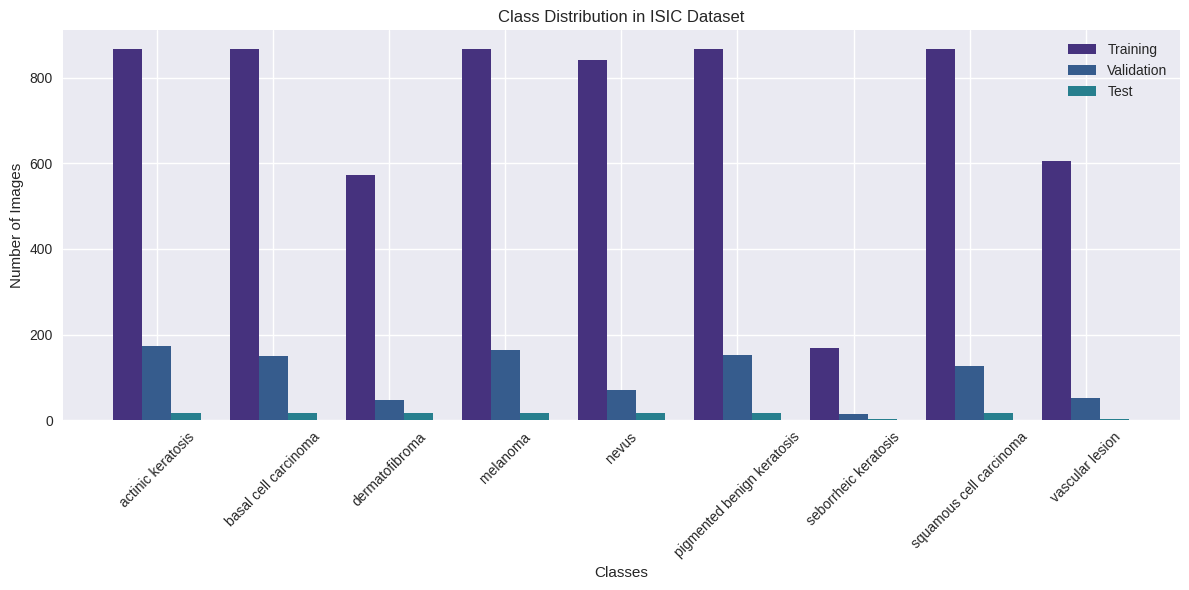

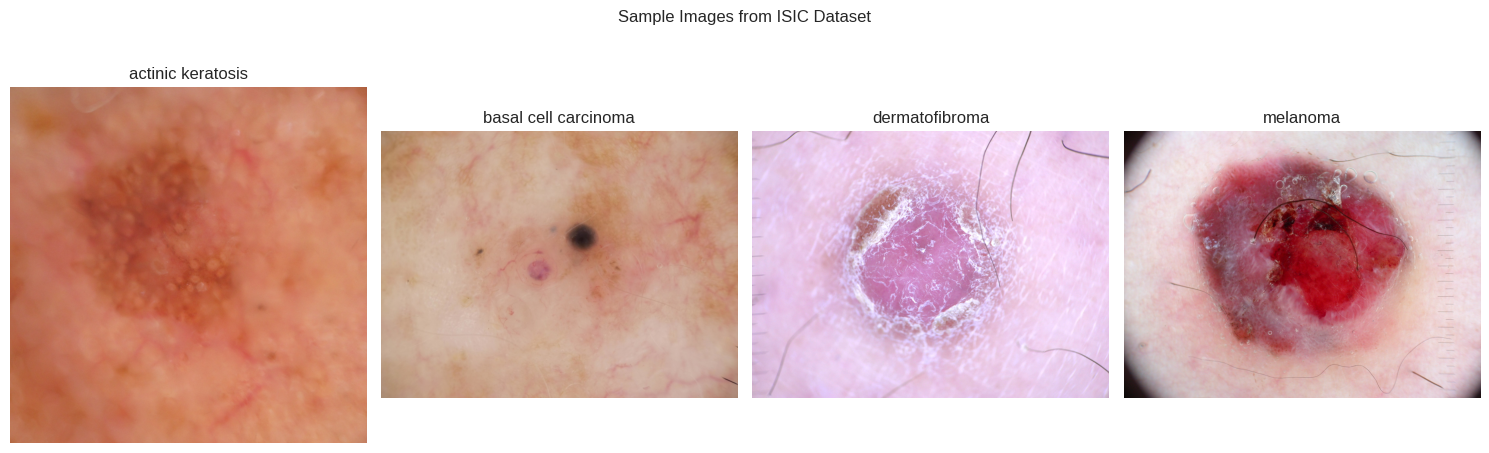

In [ ]:
# Define constants
IMG_HEIGHT = 224  # Reduced for efficiency
IMG_WIDTH = 224
BATCH_SIZE = 16
NUM_CLASSES = len(class_names)
EPOCHS = 30

# Function to check image validity
def check_image_validity(image_path):
    """Check if an image is valid and can be loaded."""
    try:
        if not os.path.exists(image_path) or os.path.getsize(image_path) == 0:
            return False
        img = cv2.imread(image_path)
        if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
            return False
        return True
    except:
        return False

# Function to analyze dataset
def analyze_dataset(dataset_dir, dataset_type="Dataset"):
    """Analyze dataset and return statistics."""
    class_counts = {}
    total_images = 0
    corrupt_images = []
    class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
    print(f"\n{dataset_type} - Found {len(class_names)} classes: {class_names}")

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        valid_count = 0
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            if check_image_validity(img_path):
                valid_count += 1
            else:
                corrupt_images.append(img_path)
        class_counts[class_name] = valid_count
        total_images += valid_count
        print(f"  - {class_name}: {valid_count} images")

    return {
        'class_names': class_names,
        'class_counts': class_counts,
        'total_images': total_images,
        'corrupt_images': corrupt_images
    }

# Analyze datasets
print("\n=== SKIN CANCER DATASET ANALYSIS ===")
train_stats = analyze_dataset(train_dir_stratified, "Training")
val_stats = analyze_dataset(val_dir_stratified, "Validation")
test_stats = analyze_dataset(test_dir, "Test")

# Create DataFrame for visualization
df_train = pd.DataFrame({
    'Class': list(train_stats['class_counts'].keys()),
    'Training Images': list(train_stats['class_counts'].values())
}).sort_values('Class')
df_val = pd.DataFrame({
    'Class': list(val_stats['class_counts'].keys()),
    'Validation Images': list(val_stats['class_counts'].values())
}).sort_values('Class')
df_test = pd.DataFrame({
    'Class': list(test_stats['class_counts'].keys()),
    'Test Images': list(test_stats['class_counts'].values())
}).sort_values('Class')

df = df_train.merge(df_val, on='Class').merge(df_test, on='Class')
df['Total'] = df['Training Images'] + df['Validation Images'] + df['Test Images']
df['Training %'] = (df['Training Images'] / df['Training Images'].sum() * 100).round(2)
df['Validation %'] = (df['Validation Images'] / df['Validation Images'].sum() * 100).round(2)
df['Test %'] = (df['Test Images'] / df['Test Images'].sum() * 100).round(2)

print("\nClass Distribution:")
print(df)

# Visualize class distribution
plt.figure(figsize=(12, 6))
index = np.arange(len(df['Class']))
width = 0.25
plt.bar(index - width, df['Training Images'], width, label='Training')
plt.bar(index, df['Validation Images'], width, label='Validation')
plt.bar(index + width, df['Test Images'], width, label='Test')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in ISIC Dataset')
plt.xticks(index, df['Class'], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('plots/class_distribution.png', dpi=300)
plt.show()

# Visualize sample images
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(class_names[:4]):
    class_path = os.path.join(train_dir_stratified, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
plt.suptitle('Sample Images from ISIC Dataset')
plt.tight_layout()
plt.savefig('plots/sample_images.png', dpi=300)
plt.show()

Found 6522 images belonging to 9 classes.
Found 951 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Training samples: 6522
Validation samples: 951
Test samples: 118


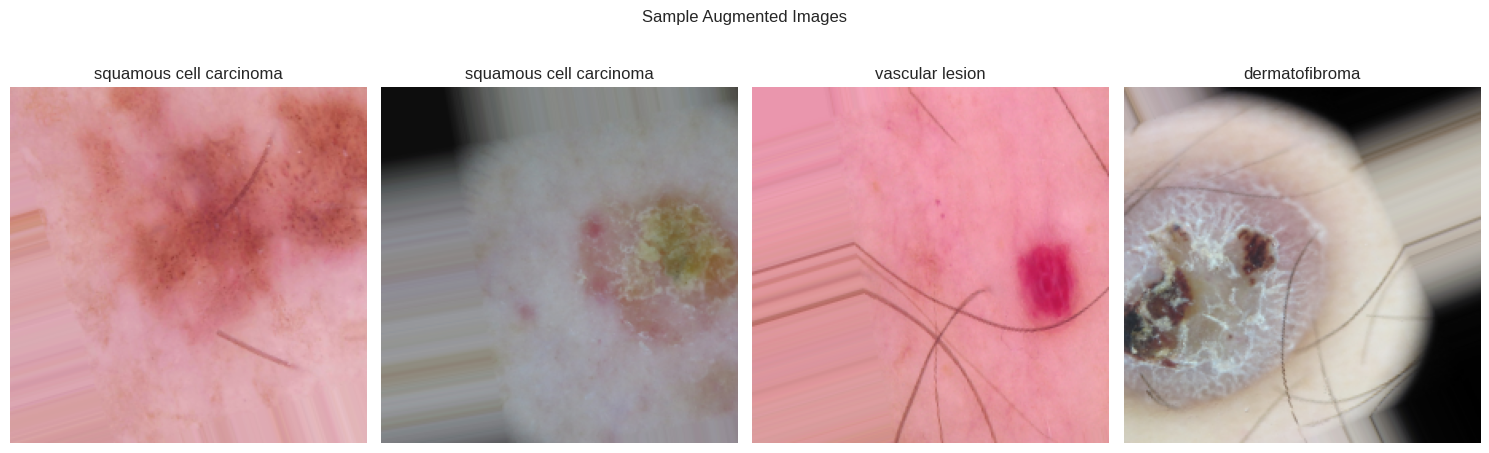

In [ ]:
# Create data generators for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,           # Increased for lesion variability
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,            # Add shear for robustness
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir_stratified,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir_stratified,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Visualize augmented images
plt.figure(figsize=(15, 5))
batch = next(train_generator)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(batch[0][i])
    label_idx = np.argmax(batch[1][i])
    plt.title(class_names[label_idx])
    plt.axis('off')
plt.suptitle('Sample Augmented Images')
plt.tight_layout()
plt.savefig('plots/augmented_images.png', dpi=300)
plt.show()

In [ ]:
# Define the baseline CNN model
from tensorflow.keras.models import Sequential # Import Sequential here
def create_baseline_model():
    """Build a CNN with 3 conv layers, 3 dense layers, and an output layer."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Create and compile the model
model_baseline = create_baseline_model()
model_baseline.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for stability
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("Baseline Model Summary:")
model_baseline.summary() # Changed from baseline_model to model_baseline

Baseline Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,286,409 (85.02 MB)

 Trainable params: 22,286,409 (85.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/models/baseline_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [ ]:

# Train the model
print("Training Baseline Model...")
history = baseline_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)

Training Baseline Model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.1362 - loss: 2.1832
Epoch 1: val_accuracy improved from -inf to 0.09779, saving model to /content/drive/My Drive/models/baseline_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 348ms/step - accuracy: 0.1362 - loss: 2.1831 - val_accuracy: 0.0978 - val_loss: 2.2487
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.2264 - loss: 2.0183
Epoch 2: val_accuracy improved from 0.09779 to 0.27234, saving model to /content/drive/My Drive/models/baseline_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 137s 335ms/step - accuracy: 0.2264 - loss: 2.0181 - val_accuracy: 0.2723 - val_loss: 1.9252
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.2771 - loss: 1.8373
Epoch 3: val_accuracy did not improve from 0.27234
408/408 ━━━━━━━━━━━━━━━━━━━━ 133s 326ms/step - accuracy: 0.2771 - loss: 1.8373 - val_accuracy: 0.2639 - val_loss: 1.8875
Epoch 4/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.2990 - loss: 1.7604
Epoch 4: val_accuracy improved from 0.27234 to 0.31230, saving model to /content/drive/My Drive/models/baseline_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 138s 338ms/step - accuracy: 0.2990 - loss: 1.7604 - val_accuracy: 0.3123 - val_loss: 1.8434
Epoch 5/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3378 - loss: 1.7091
Epoch 5: val_accuracy improved from 0.31230 to 0.31651, saving model to /content/drive/My Drive/models/baseline_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 137s 336ms/step - accuracy: 0.3378 - loss: 1.7091 - val_accuracy: 0.3165 - val_loss: 1.8157
Epoch 6/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3431 - loss: 1.6429
Epoch 6: val_accuracy improved from 0.31651 to 0.36278, saving model to /content/drive/My Drive/models/baseline_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 137s 335ms/step - accuracy: 0.3430 - loss: 1.6430 - val_accuracy: 0.3628 - val_loss: 1.7256
Epoch 7/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3500 - loss: 1.6700
Epoch 7: val_accuracy did not improve from 0.36278
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 328ms/step - accuracy: 0.3500 - loss: 1.6699 - val_accuracy: 0.3512 - val_loss: 1.7205
Epoch 8/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3565 - loss: 1.6347
Epoch 8: val_accuracy did not improve from 0.36278
408/408 ━━━━━━━━━━━━━━━━━━━━ 135s 330ms/step - accuracy: 0.3565 - loss: 1.6346 - val_accuracy: 0.3260 - val_loss: 1.7543
Epoch 9/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3741 - loss: 1.6108
Epoch 9: val_accuracy did not improve from 0.36278
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 329ms/step - accuracy: 0.3741 - loss: 1.6107 - val_accuracy: 0.3491 - val_loss: 1.7356
Epoch 10/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3902 - loss: 1.5269
Epoch 10: 

408/408 ━━━━━━━━━━━━━━━━━━━━ 136s 334ms/step - accuracy: 0.3852 - loss: 1.5555 - val_accuracy: 0.3922 - val_loss: 1.6107
Epoch 12/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.4083 - loss: 1.5097
Epoch 12: val_accuracy did not improve from 0.39222
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 329ms/step - accuracy: 0.4083 - loss: 1.5097 - val_accuracy: 0.3596 - val_loss: 1.6542
Epoch 13/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3915 - loss: 1.5136
Epoch 13: val_accuracy did not improve from 0.39222
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 328ms/step - accuracy: 0.3915 - loss: 1.5136 - val_accuracy: 0.3807 - val_loss: 1.6231
Epoch 14/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3996 - loss: 1.4939
Epoch 14: val_accuracy improved from 0.39222 to 0.40484, saving model to /content/drive/My Drive/models/baseline_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 137s 335ms/step - accuracy: 0.3996 - loss: 1.4938 - val_accuracy: 0.4048 - val_loss: 1.5758
Epoch 15/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4133 - loss: 1.4619
Epoch 15: val_accuracy improved from 0.40484 to 0.43007, saving model to /content/drive/My Drive/models/baseline_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 136s 334ms/step - accuracy: 0.4133 - loss: 1.4619 - val_accuracy: 0.4301 - val_loss: 1.5635
Epoch 16/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4258 - loss: 1.4467
Epoch 16: val_accuracy did not improve from 0.43007
408/408 ━━━━━━━━━━━━━━━━━━━━ 135s 330ms/step - accuracy: 0.4258 - loss: 1.4468 - val_accuracy: 0.3859 - val_loss: 1.6194
Epoch 17/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4215 - loss: 1.4055
Epoch 17: val_accuracy did not improve from 0.43007
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 327ms/step - accuracy: 0.4215 - loss: 1.4056 - val_accuracy: 0.3880 - val_loss: 1.6262
Epoch 18/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4244 - loss: 1.4479
Epoch 18: val_accuracy did not improve from 0.43007
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 328ms/step - accuracy: 0.4244 - loss: 1.4479 - val_accuracy: 0.3670 - val_loss: 1.6677
Epoch 19/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4283 - loss: 1.4134
Epoc

408/408 ━━━━━━━━━━━━━━━━━━━━ 136s 334ms/step - accuracy: 0.4364 - loss: 1.3938 - val_accuracy: 0.4406 - val_loss: 1.5522
Epoch 22/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4587 - loss: 1.3516
Epoch 22: val_accuracy did not improve from 0.44059
408/408 ━━━━━━━━━━━━━━━━━━━━ 135s 330ms/step - accuracy: 0.4587 - loss: 1.3516 - val_accuracy: 0.3985 - val_loss: 1.5664
Epoch 23/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.4468 - loss: 1.3297
Epoch 23: val_accuracy did not improve from 0.44059
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 329ms/step - accuracy: 0.4468 - loss: 1.3297 - val_accuracy: 0.4185 - val_loss: 1.5354
Epoch 24/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4665 - loss: 1.3464
Epoch 24: val_accuracy did not improve from 0.44059
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 329ms/step - accuracy: 0.4665 - loss: 1.3463 - val_accuracy: 0.4395 - val_loss: 1.5276
Epoch 25/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4794 - loss: 1.2903
Epoc

408/408 ━━━━━━━━━━━━━━━━━━━━ 135s 332ms/step - accuracy: 0.4785 - loss: 1.2794 - val_accuracy: 0.4564 - val_loss: 1.4659
Epoch 29/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4751 - loss: 1.2835
Epoch 29: val_accuracy did not improve from 0.45636
408/408 ━━━━━━━━━━━━━━━━━━━━ 133s 325ms/step - accuracy: 0.4751 - loss: 1.2835 - val_accuracy: 0.4511 - val_loss: 1.4618
Epoch 30/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4970 - loss: 1.2658
Epoch 30: val_accuracy did not improve from 0.45636
408/408 ━━━━━━━━━━━━━━━━━━━━ 144s 329ms/step - accuracy: 0.4970 - loss: 1.2658 - val_accuracy: 0.4427 - val_loss: 1.4810
Restoring model weights from the end of the best epoch: 29.


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.4264 - loss: 1.5164
Validation Accuracy: 0.4564
Validation Loss: 1.4659
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.2993 - loss: 1.7541
Test Accuracy: 0.3898
Test Loss: 1.6612
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 690ms/step

Classification Report (Full Test Set):
                            precision    recall  f1-score   support

         actinic keratosis     0.1667    0.0625    0.0909        16
      basal cell carcinoma     0.3889    0.4375    0.4118        16
            dermatofibroma     0.5000    0.2500    0.3333        16
                  melanoma     0.4615    0.3750    0.4138        16
                     nevus     0.3704    0.6250    0.4651        16
pigmented benign keratosis     0.4615    0.3750    0.4138        16
      seborrheic keratosis     0.6667    0.6667    0.6667         3
   squamous cell carcinoma     0.2800    0.4375    0.3415        16
           vascular lesion  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


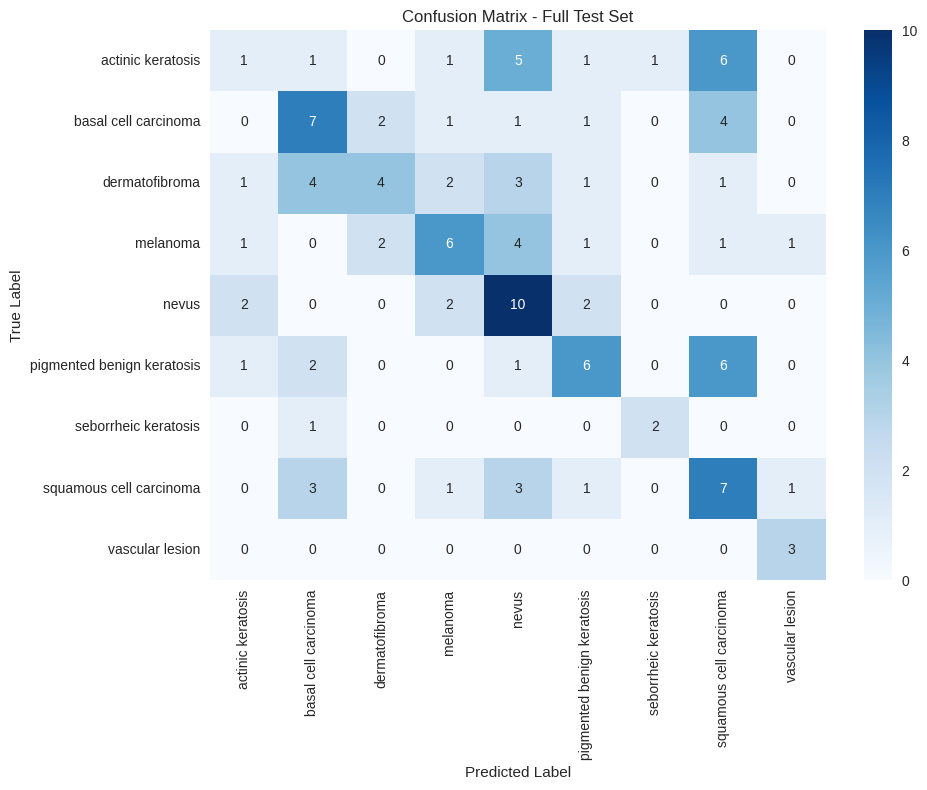

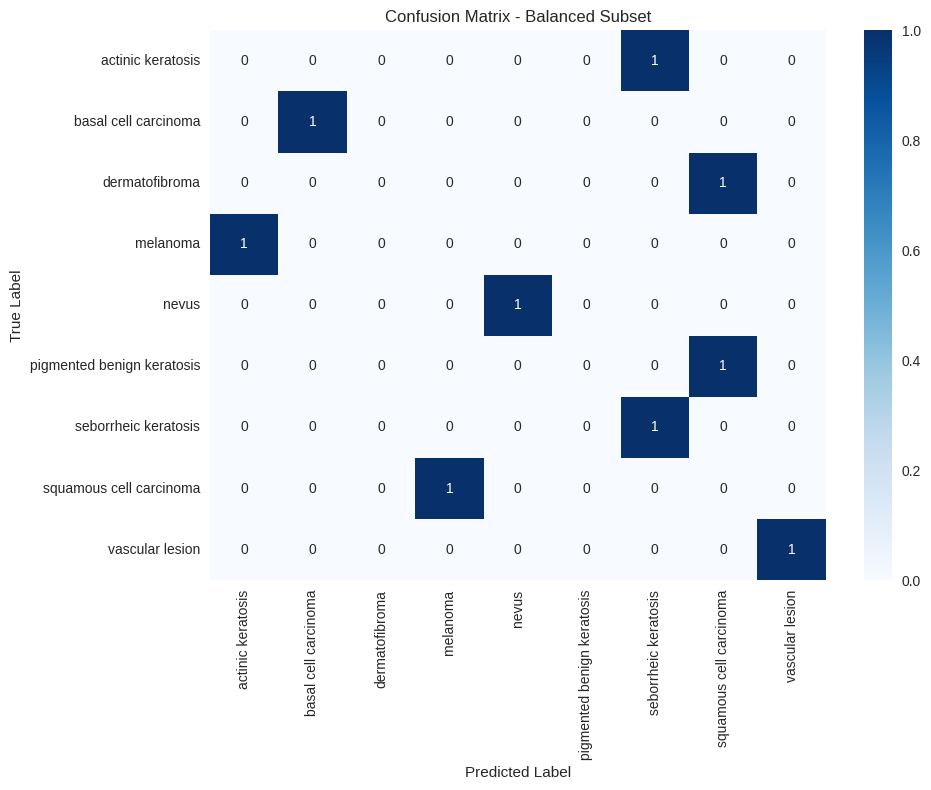

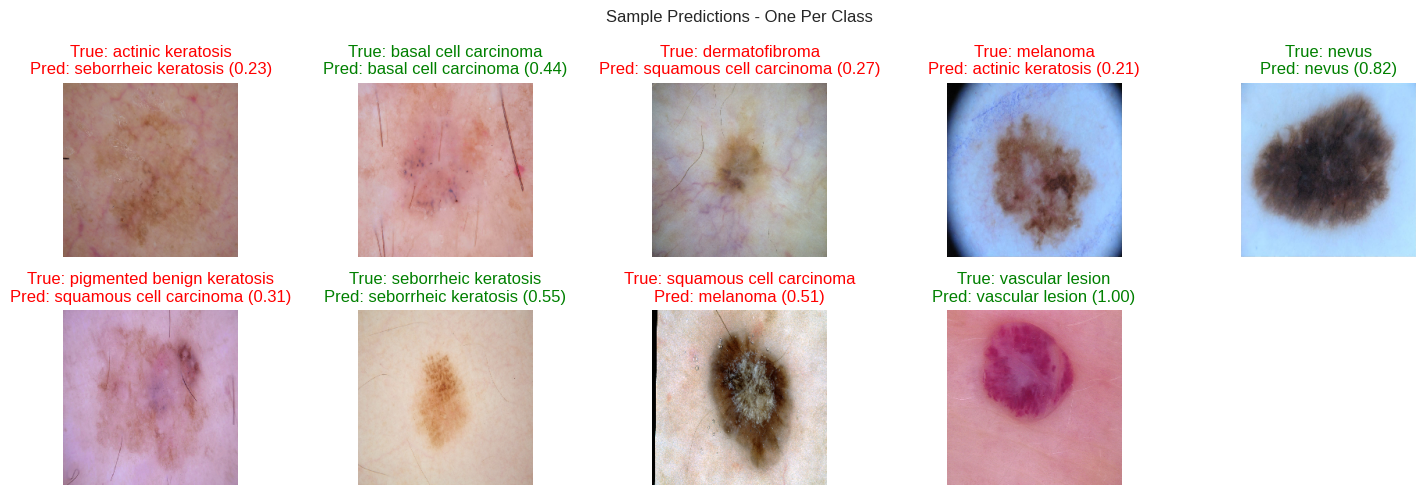


Key Observations:
1. Test Accuracy (Full Set): 0.3898


In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('/content/drive/My Drive/models/baseline_best.h5')

# Evaluate on validation set
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Collect predictions for a balanced subset of test images (at least one per class)
test_generator.reset()
class_to_indices = {i: [] for i in range(NUM_CLASSES)}
all_images = []
all_labels = []

# Collect indices of images for each class
for i in range(len(test_generator)):
    batch_images, batch_labels = next(test_generator)
    for j in range(len(batch_images)):
        class_idx = np.argmax(batch_labels[j])
        class_to_indices[class_idx].append((i, j))

# Ensure at least one image per class for evaluation
selected_images = []
selected_labels = []
for class_idx in range(NUM_CLASSES):
    if class_to_indices[class_idx]:
        batch_idx, img_idx = class_to_indices[class_idx][0]  # Take the first image for this class
        # Reset generator and fetch the batch
        test_generator.reset()
        for _ in range(batch_idx + 1):
            batch_images, batch_labels = next(test_generator)
        selected_images.append(batch_images[img_idx])
        selected_labels.append(batch_labels[img_idx])
    else:
        print(f"Warning: No test images found for class {class_names[class_idx]}")

selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

# Predict on the balanced subset
balanced_predictions = best_model.predict(selected_images)
balanced_pred_classes = np.argmax(balanced_predictions, axis=1)
balanced_true_classes = np.argmax(selected_labels, axis=1)

# Predict on the full test set for overall metrics
test_generator.reset()
all_predictions = best_model.predict(test_generator)
all_pred_classes = np.argmax(all_predictions, axis=1)
all_true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report for the full test set
print("\nClassification Report (Full Test Set):")
print(classification_report(all_true_classes, all_pred_classes, target_names=class_names, digits=4))

# Print classification report for the balanced subset
print("\nClassification Report (Balanced Subset):")
print(classification_report(balanced_true_classes, balanced_pred_classes, target_names=class_names, digits=4))

# Plot confusion matrix for the full test set
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_true_classes, all_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Full Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('plots/confusion_matrix_full.png', dpi=300)
plt.show()

# Plot confusion matrix for the balanced subset
plt.figure(figsize=(10, 8))
cm_balanced = confusion_matrix(balanced_true_classes, balanced_pred_classes)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Balanced Subset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('plots/confusion_matrix_balanced.png', dpi=300)
plt.show()
# Visualize sample predictions (one image per class)
plt.figure(figsize=(15, 5))
for i in range(min(NUM_CLASSES, len(selected_images))):
    plt.subplot(2, 5, i+1)
    plt.imshow(selected_images[i])
    true_label = class_names[balanced_true_classes[i]]
    pred_label = class_names[balanced_pred_classes[i]]
    confidence = np.max(balanced_predictions[i])
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2f})', color=color)
    plt.axis('off')
plt.suptitle('Sample Predictions - One Per Class')
plt.tight_layout()
plt.savefig('plots/sample_predictions_all_classes.png', dpi=300)
plt.show()

# Key observations
print("\nKey Observations:")
print(f"1. Test Accuracy (Full Set): {test_accuracy:.4f}")

In [ ]:

from tensorflow.keras.layers import GlobalAveragePooling2D, SeparableConv2D, Activation
from tensorflow.keras.regularizers import l2


def create_improved_deeper_model():
    """Build an improved deeper CNN with better regularization and architecture."""
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (
        Input, Conv2D, MaxPooling2D, BatchNormalization,
        Dropout, Dense, GlobalAveragePooling2D, SeparableConv2D,
        Activation
    )
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Entry Block - Start with more filters
        Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 1
        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Block 2 - Use Separable Convolution for efficiency
        SeparableConv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.35),

        # Block 3
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        # Block 4 - Deep features
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),

        # Use Global Average Pooling instead of Flatten
        GlobalAveragePooling2D(),

        # Classifier
        Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Alternative: Simplified version without Activation layer
def create_improved_deeper_model_simplified():
    """Build an improved deeper CNN with better regularization and architecture (simplified)."""
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (
        Input, Conv2D, MaxPooling2D, BatchNormalization,
        Dropout, Dense, GlobalAveragePooling2D, SeparableConv2D
    )
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Entry Block
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Block 2
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.35),

        # Block 3
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        # Block 4
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),

        # Use Global Average Pooling instead of Flatten
        GlobalAveragePooling2D(),

        # Classifier
        Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Custom learning rate scheduler
def lr_schedule(epoch):
    """Learning rate schedule"""
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    elif epoch < 30:
        return 0.0001
    else:
        return 0.00005

# Create the model (use the simplified version to avoid import issues)
improved_model = create_improved_deeper_model_simplified()

# Improved data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

# Create new generators with the improved augmentation
train_generator_improved = train_datagen.flow_from_directory(
    train_dir_stratified,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Improved callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

callbacks_improved = [
    ModelCheckpoint(
        '/content/drive/My Drive/models/improved_deep_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    LearningRateScheduler(lr_schedule, verbose=1)
]

# Compile the improved model
from tensorflow.keras.optimizers import Adam

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

improved_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("Improved Deep Model Summary:")
improved_model.summary()

# Train the improved model
print("\nTraining Improved Deep Model...")
history_improved = improved_model.fit(
    train_generator_improved,
    steps_per_epoch=len(train_generator_improved),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_improved,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate the improved model
print("\nEvaluating Improved Deep Model...")
test_loss_improved, test_accuracy_improved = improved_model.evaluate(test_generator)
print(f"Improved Deep Model Test Accuracy: {test_accuracy_improved:.4f}")
print(f"Improved Deep Model Test Loss: {test_loss_improved:.4f}")

# Compare with baseline
print("\nComparison:")
print(f"Baseline Test Accuracy: {test_accuracy_baseline:.4f}")
print(f"Improved Deep Model Test Accuracy: {test_accuracy_improved:.4f}")
print(f"Improvement: {test_accuracy_improved - test_accuracy_baseline:.4f}")

# Test-Time Augmentation function
def test_time_augmentation(model, test_gen, num_augmentations=5):
    """Apply test-time augmentation for better predictions"""
    predictions = []

    for i in range(num_augmentations):
        test_gen.reset()
        print(f"TTA iteration {i+1}/{num_augmentations}")
        pred = model.predict(test_gen, verbose=0)
        predictions.append(pred)

    # Average predictions
    return np.mean(predictions, axis=0)

# Apply TTA for final evaluation
print("\nApplying Test-Time Augmentation...")
tta_predictions = test_time_augmentation(improved_model, test_generator)
tta_pred_classes = np.argmax(tta_predictions, axis=1)

# Calculate TTA accuracy
test_generator.reset()
true_classes = test_generator.classes
tta_accuracy = np.mean(tta_pred_classes == true_classes)

print(f"\nFinal Results:")
print(f"Regular Test Accuracy: {test_accuracy_improved:.4f}")
print(f"TTA Test Accuracy: {tta_accuracy:.4f}")
print(f"TTA Improvement: {tta_accuracy - test_accuracy_improved:.4f}")

Found 6522 images belonging to 9 classes.
Improved Deep Model Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,885,545 (18.64 MB)

 Trainable params: 4,881,577 (18.62 MB)

 Non-trainable params: 3,968 (15.50 KB)


Training Improved Deep Model...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.1263 - loss: 3.6936
Epoch 1: val_accuracy improved from -inf to 0.13249, saving model to /content/drive/My Drive/models/improved_deep_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 190s 423ms/step - accuracy: 0.1263 - loss: 3.6930 - val_accuracy: 0.1325 - val_loss: 2.9972 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.1098 - loss: 2.9559
Epoch 2: val_accuracy did not improve from 0.13249
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 363ms/step - accuracy: 0.1098 - loss: 2.9556 - val_accuracy: 0.0179 - val_loss: 2.7409 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.1429 - loss: 2.6447
Epoch 3: val_accuracy did not improve from 0.13249
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 364ms/step - accuracy: 0.1429 - loss: 2.6445 - val_accuracy: 0.0820 - val_loss: 2.5327 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1485 - loss: 2.4540
Epoch 4

408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 367ms/step - accuracy: 0.1573 - loss: 2.4350 - val_accuracy: 0.1399 - val_loss: 2.4324 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1804 - loss: 2.3286
Epoch 6: val_accuracy improved from 0.13985 to 0.16193, saving model to /content/drive/My Drive/models/improved_deep_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 365ms/step - accuracy: 0.1804 - loss: 2.3285 - val_accuracy: 0.1619 - val_loss: 2.3282 - learning_rate: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.001.
Epoch 7/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1658 - loss: 2.2941
Epoch 7: val_accuracy improved from 0.16193 to 0.21451, saving model to /content/drive/My Drive/models/improved_deep_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 368ms/step - accuracy: 0.1658 - loss: 2.2942 - val_accuracy: 0.2145 - val_loss: 2.2867 - learning_rate: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.001.
Epoch 8/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1784 - loss: 2.2832
Epoch 8: val_accuracy did not improve from 0.21451
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 361ms/step - accuracy: 0.1784 - loss: 2.2832 - val_accuracy: 0.1777 - val_loss: 2.3452 - learning_rate: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.001.
Epoch 9/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1773 - loss: 2.2964
Epoch 9: val_accuracy did not improve from 0.21451
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 362ms/step - accuracy: 0.1773 - loss: 2.2964 - val_accuracy: 0.1009 - val_loss: 2.3137 - learning_rate: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.001.
Epoch 10/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.1792 - loss: 2.2448
Epoch

408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 367ms/step - accuracy: 0.2250 - loss: 2.0927 - val_accuracy: 0.2156 - val_loss: 2.2263 - learning_rate: 5.0000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0005.
Epoch 20/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2488 - loss: 2.0437
Epoch 20: val_accuracy improved from 0.21556 to 0.24816, saving model to /content/drive/My Drive/models/improved_deep_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 366ms/step - accuracy: 0.2488 - loss: 2.0437 - val_accuracy: 0.2482 - val_loss: 2.1072 - learning_rate: 5.0000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0001.
Epoch 21/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.2745 - loss: 1.9698
Epoch 21: val_accuracy did not improve from 0.24816
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 360ms/step - accuracy: 0.2745 - loss: 1.9697 - val_accuracy: 0.2355 - val_loss: 2.0396 - learning_rate: 1.0000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0001.
Epoch 22/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.2733 - loss: 1.9213
Epoch 22: val_accuracy improved from 0.24816 to 0.26498, saving model to /content/drive/My Drive/models/improved_deep_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 366ms/step - accuracy: 0.2734 - loss: 1.9213 - val_accuracy: 0.2650 - val_loss: 2.0381 - learning_rate: 1.0000e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0001.
Epoch 23/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.2752 - loss: 1.8825
Epoch 23: val_accuracy improved from 0.26498 to 0.27234, saving model to /content/drive/My Drive/models/improved_deep_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 151s 369ms/step - accuracy: 0.2752 - loss: 1.8825 - val_accuracy: 0.2723 - val_loss: 2.0000 - learning_rate: 1.0000e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0001.
Epoch 24/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2794 - loss: 1.8937
Epoch 24: val_accuracy did not improve from 0.27234
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 360ms/step - accuracy: 0.2794 - loss: 1.8937 - val_accuracy: 0.2629 - val_loss: 1.9899 - learning_rate: 1.0000e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0001.
Epoch 25/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2789 - loss: 1.8491
Epoch 25: val_accuracy did not improve from 0.27234
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 361ms/step - accuracy: 0.2789 - loss: 1.8492 - val_accuracy: 0.1903 - val_loss: 2.2448 - learning_rate: 1.0000e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0001.
Epoch 26/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2923

408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 366ms/step - accuracy: 0.2910 - loss: 1.8148 - val_accuracy: 0.2734 - val_loss: 2.0022 - learning_rate: 1.0000e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0001.
Epoch 28/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2921 - loss: 1.7922
Epoch 28: val_accuracy did not improve from 0.27340
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 362ms/step - accuracy: 0.2921 - loss: 1.7922 - val_accuracy: 0.2366 - val_loss: 1.9974 - learning_rate: 1.0000e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0001.
Epoch 29/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.3108 - loss: 1.7875
Epoch 29: val_accuracy improved from 0.27340 to 0.31335, saving model to /content/drive/My Drive/models/improved_deep_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 365ms/step - accuracy: 0.3108 - loss: 1.7875 - val_accuracy: 0.3134 - val_loss: 1.8959 - learning_rate: 1.0000e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0001.
Epoch 30/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.3016 - loss: 1.7891
Epoch 30: val_accuracy did not improve from 0.31335
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 360ms/step - accuracy: 0.3017 - loss: 1.7891 - val_accuracy: 0.2808 - val_loss: 1.9019 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 29.

Evaluating Improved Deep Model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3174 - loss: 2.0908
Improved Deep Model Test Accuracy: 0.3220
Improved Deep Model Test Loss: 1.9712

Comparison:
Baseline Test Accuracy: 0.3898
Improved Deep Model Test Accuracy: 0.3220
Improvement: -0.0678

Applying Test-Time Augmentation...
TTA iteration 1/5
TTA iteration 2/5
TTA iteration 3/5
TTA iteration 4/5
TTA iteration 5/5

Final Results:
R

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Training Improved Deep Model with SGD...
Epoch 1/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.1207 - loss: 3.4981
Epoch 1: val_accuracy improved from -inf to 0.02734, saving model to /content/drive/My Drive/models/improved_deep_sgd_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 172s 388ms/step - accuracy: 0.1206 - loss: 3.4978 - val_accuracy: 0.0273 - val_loss: 3.2497 - learning_rate: 0.0100
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1042 - loss: 3.1933
Epoch 2: val_accuracy improved from 0.02734 to 0.06835, saving model to /content/drive/My Drive/models/improved_deep_sgd_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 367ms/step - accuracy: 0.1042 - loss: 3.1932 - val_accuracy: 0.0683 - val_loss: 3.1374 - learning_rate: 0.0100
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1288 - loss: 3.0848
Epoch 3: val_accuracy improved from 0.06835 to 0.09253, saving model to /content/drive/My Drive/models/improved_deep_sgd_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 367ms/step - accuracy: 0.1288 - loss: 3.0848 - val_accuracy: 0.0925 - val_loss: 3.0397 - learning_rate: 0.0100
Epoch 4/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1054 - loss: 3.0430
Epoch 4: val_accuracy improved from 0.09253 to 0.20294, saving model to /content/drive/My Drive/models/improved_deep_sgd_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 367ms/step - accuracy: 0.1054 - loss: 3.0429 - val_accuracy: 0.2029 - val_loss: 2.9426 - learning_rate: 0.0100
Epoch 5/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1375 - loss: 2.9430
Epoch 5: val_accuracy did not improve from 0.20294
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 361ms/step - accuracy: 0.1374 - loss: 2.9430 - val_accuracy: 0.1809 - val_loss: 2.8532 - learning_rate: 0.0100
Epoch 6/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.0985 - loss: 2.9109
Epoch 6: val_accuracy did not improve from 0.20294
408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 365ms/step - accuracy: 0.0985 - loss: 2.9109 - val_accuracy: 0.0936 - val_loss: 2.8897 - learning_rate: 0.0100
Epoch 7/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1446 - loss: 2.8432
Epoch 7: val_accuracy did not improve from 0.20294
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 362ms/step - accuracy: 0.1445 - loss: 2.8431 - val_accuracy: 0.0578 - val_loss: 2.8419 - learning_rate: 0.0100
Epo

408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 364ms/step - accuracy: 0.1927 - loss: 2.4150 - val_accuracy: 0.2492 - val_loss: 2.4194 - learning_rate: 0.0025
Epoch 19/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.2153 - loss: 2.3526
Epoch 19: val_accuracy did not improve from 0.24921
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 362ms/step - accuracy: 0.2153 - loss: 2.3526 - val_accuracy: 0.2376 - val_loss: 2.3911 - learning_rate: 0.0025
Epoch 20/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2235 - loss: 2.3821
Epoch 20: val_accuracy did not improve from 0.24921
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 361ms/step - accuracy: 0.2235 - loss: 2.3820 - val_accuracy: 0.1714 - val_loss: 2.5221 - learning_rate: 0.0025
Epoch 21/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.2299 - loss: 2.3407
Epoch 21: val_accuracy did not improve from 0.24921
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 361ms/step - accuracy: 0.2299 - loss: 2.3406 - val_accuracy: 0.2324 - val_loss: 2.3747 - learning_rate: 0.00

408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 367ms/step - accuracy: 0.2467 - loss: 2.2393 - val_accuracy: 0.2713 - val_loss: 2.2976 - learning_rate: 0.0012
Epoch 27/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.2482 - loss: 2.2294
Epoch 27: val_accuracy did not improve from 0.27129
408/408 ━━━━━━━━━━━━━━━━━━━━ 147s 359ms/step - accuracy: 0.2482 - loss: 2.2294 - val_accuracy: 0.2461 - val_loss: 2.3734 - learning_rate: 0.0012
Epoch 28/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.2475 - loss: 2.2247
Epoch 28: val_accuracy improved from 0.27129 to 0.27340, saving model to /content/drive/My Drive/models/improved_deep_sgd_best.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 366ms/step - accuracy: 0.2475 - loss: 2.2247 - val_accuracy: 0.2734 - val_loss: 2.2731 - learning_rate: 0.0012
Epoch 29/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.2602 - loss: 2.2172
Epoch 29: val_accuracy did not improve from 0.27340
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 362ms/step - accuracy: 0.2602 - loss: 2.2172 - val_accuracy: 0.1882 - val_loss: 2.4248 - learning_rate: 0.0012
Epoch 30/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2582 - loss: 2.2403
Epoch 30: val_accuracy did not improve from 0.27340
408/408 ━━━━━━━━━━━━━━━━━━━━ 146s 358ms/step - accuracy: 0.2581 - loss: 2.2402 - val_accuracy: 0.2734 - val_loss: 2.3142 - learning_rate: 0.0012
Restoring model weights from the end of the best epoch: 28.

Evaluating SGD Model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 828ms/step - accuracy: 0.2091 - loss: 2.3448
SGD Model Test Accuracy: 0.2966
SGD Model Test Loss: 2.2257

=== MODEL COMPARISON ===
Baseline Test Accuracy: 0.3898
Improved

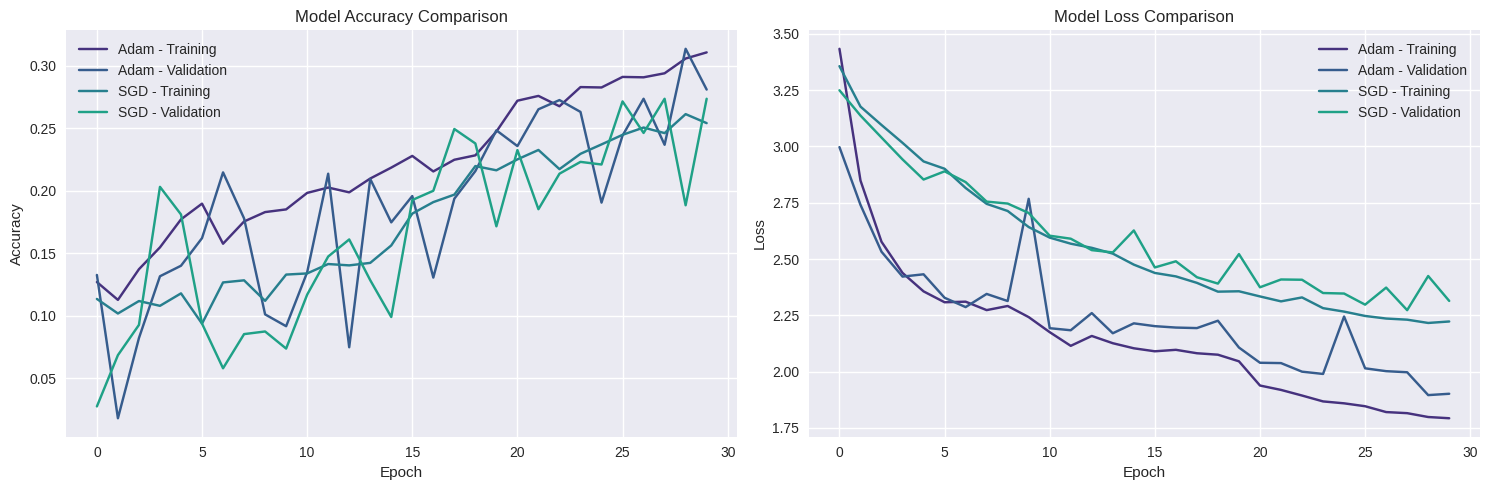


Convergence Analysis:
Adam reached best validation accuracy in: 29 epochs
SGD reached best validation accuracy in: 28 epochs
Adam best validation accuracy: 0.3134
SGD best validation accuracy: 0.2734

=== DETAILED MODEL COMPARISON ===
          Model Optimizer  Learning Rate  Test Accuracy  Test Loss  Parameters
       Baseline      Adam         0.0001       0.389830   1.661176    22286409
Improved (Adam)      Adam         0.0010       0.322034   1.971220     4885545
 Improved (SGD)       SGD         0.0100       0.296610   2.225662     4885545

Comparison saved to plots/model_comparison.csv


In [ ]:
# Train the deeper model with SGD optimizer
from tensorflow.keras.optimizers import SGD

improved_model_sgd = create_improved_deeper_model_simplified()

# Compile with SGD optimizer (with adjusted learning rate)
optimizer_sgd = SGD(
    learning_rate=0.01,  # Higher learning rate for SGD
    momentum=0.9,
    decay=1e-6,
    nesterov=True
)

improved_model_sgd.compile(
    optimizer=optimizer_sgd,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Update callbacks for SGD model
callbacks_sgd = [
    ModelCheckpoint(
        '/content/drive/My Drive/models/improved_deep_sgd_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Training Improved Deep Model with SGD...")
history_sgd = improved_model_sgd.fit(
    train_generator_improved,
    steps_per_epoch=len(train_generator_improved),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_sgd,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate the SGD model
print("\nEvaluating SGD Model...")
test_loss_sgd, test_accuracy_sgd = improved_model_sgd.evaluate(test_generator)
print(f"SGD Model Test Accuracy: {test_accuracy_sgd:.4f}")
print(f"SGD Model Test Loss: {test_loss_sgd:.4f}")

# Compare all models
print("\n=== MODEL COMPARISON ===")
print(f"Baseline Test Accuracy: {test_accuracy_baseline:.4f}")
print(f"Improved Deep Model (Adam) Test Accuracy: {test_accuracy_improved:.4f}")
print(f"Improved Deep Model (SGD) Test Accuracy: {test_accuracy_sgd:.4f}")
print(f"Adam vs Baseline Improvement: {test_accuracy_improved - test_accuracy_baseline:.4f}")
print(f"SGD vs Baseline Improvement: {test_accuracy_sgd - test_accuracy_baseline:.4f}")
print(f"Adam vs SGD Difference: {test_accuracy_improved - test_accuracy_sgd:.4f}")

# Plot training history comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['accuracy'], label='Adam - Training')
plt.plot(history_improved.history['val_accuracy'], label='Adam - Validation')
plt.plot(history_sgd.history['accuracy'], label='SGD - Training')
plt.plot(history_sgd.history['val_accuracy'], label='SGD - Validation')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='Adam - Training')
plt.plot(history_improved.history['val_loss'], label='Adam - Validation')
plt.plot(history_sgd.history['loss'], label='SGD - Training')
plt.plot(history_sgd.history['val_loss'], label='SGD - Validation')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('plots/optimizer_comparison.png', dpi=300)
plt.show()

# Convergence speed analysis
def analyze_convergence(history_adam, history_sgd):
    """Analyze convergence speed of both optimizers"""
    adam_epochs_to_best = np.argmax(history_adam.history['val_accuracy']) + 1
    sgd_epochs_to_best = np.argmax(history_sgd.history['val_accuracy']) + 1

    print(f"\nConvergence Analysis:")
    print(f"Adam reached best validation accuracy in: {adam_epochs_to_best} epochs")
    print(f"SGD reached best validation accuracy in: {sgd_epochs_to_best} epochs")
    print(f"Adam best validation accuracy: {max(history_adam.history['val_accuracy']):.4f}")
    print(f"SGD best validation accuracy: {max(history_sgd.history['val_accuracy']):.4f}")

analyze_convergence(history_improved, history_sgd)

# Create detailed comparison table
import pandas as pd

comparison_data = {
    'Model': ['Baseline', 'Improved (Adam)', 'Improved (SGD)'],
    'Optimizer': ['Adam', 'Adam', 'SGD'],
    'Learning Rate': [0.0001, 0.001, 0.01],
    'Test Accuracy': [test_accuracy_baseline, test_accuracy_improved, test_accuracy_sgd],
    'Test Loss': [test_loss_baseline, test_loss_improved, test_loss_sgd],
    'Parameters': [
        baseline_model.count_params(),
        improved_model.count_params(),
        improved_model_sgd.count_params()
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n=== DETAILED MODEL COMPARISON ===")
print(df_comparison.to_string(index=False))

# Save comparison results
df_comparison.to_csv('plots/model_comparison.csv', index=False)
print("\nComparison saved to plots/model_comparison.csv")


=== EVALUATING SAVED MODELS ===

Loading baseline...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


baseline - Test Accuracy: 0.3898, Test Loss: 1.6620

Loading improved_deep_adam...


improved_deep_adam - Test Accuracy: 0.4407, Test Loss: 1.6764

Loading improved_deep_sgd...


improved_deep_sgd - Test Accuracy: 0.2966, Test Loss: 2.2255
mobilenetv2 model not found at /content/drive/My Drive/models//transfer_final_best.h5

Loading efficient_skin...


efficient_skin - Test Accuracy: 0.2034, Test Loss: 2.0562

Loading lightweight...


lightweight - Test Accuracy: 0.1525, Test Loss: 2.8363

=== MODEL COMPARISON SUMMARY ===
                    accuracy      loss  parameters
improved_deep_adam  0.440678  1.676419   2588233.0
baseline            0.389830  1.661993  22286409.0
improved_deep_sgd   0.296610  2.225471   4885545.0
efficient_skin      0.203390  2.056228    139593.0
lightweight         0.152542  2.836334     36521.0


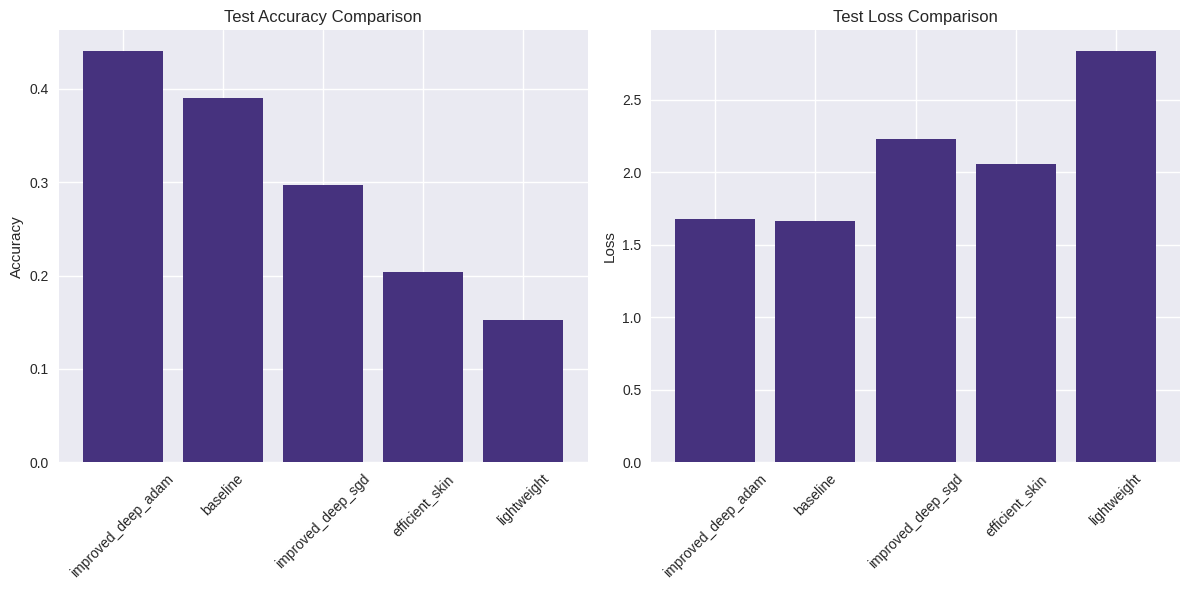


Loading best model: improved_deep_adam


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 980ms/step

Detailed Classification Report for improved_deep_adam:
                            precision    recall  f1-score   support

         actinic keratosis       0.67      0.38      0.48        16
      basal cell carcinoma       0.38      0.56      0.45        16
            dermatofibroma       0.53      0.56      0.55        16
                  melanoma       0.64      0.44      0.52        16
                     nevus       0.50      0.75      0.60        16
pigmented benign keratosis       0.17      0.19      0.18        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.60      0.19      0.29        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.44       118
                 macro avg       0.47      0.45      0.43       118
              weighted avg       0.49      0.44      0.44       118



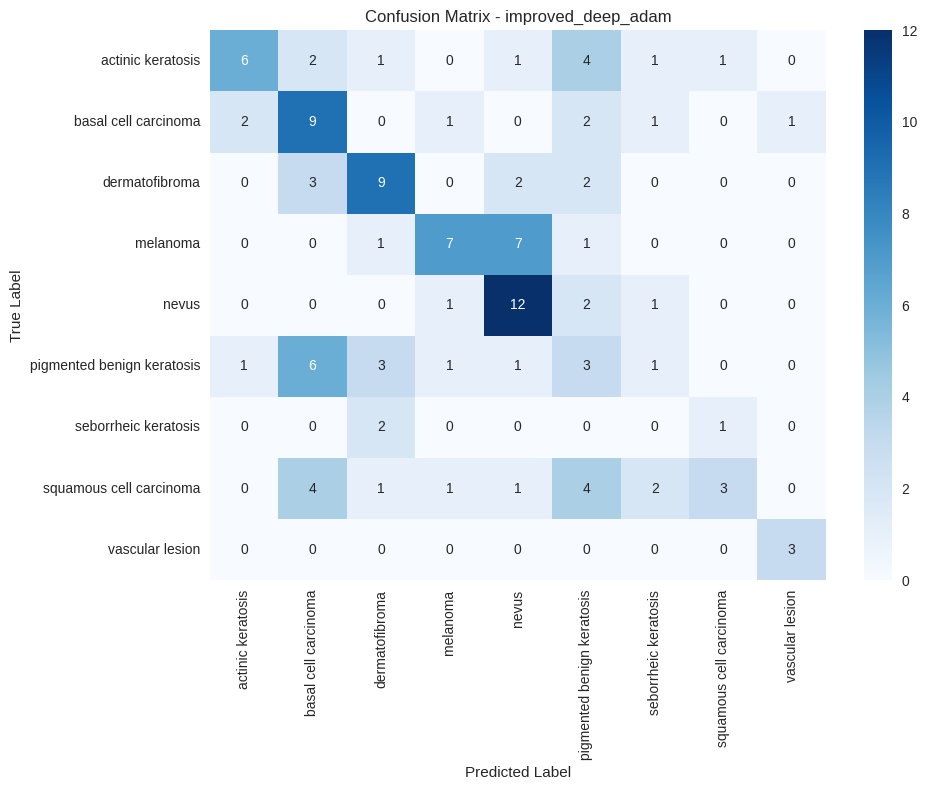

In [ ]:
# Load and evaluate saved models
from tensorflow.keras.models import load_model

# Define paths to your saved models
saved_models = {
    'baseline': '/content/drive/My Drive/models/baseline_best.h5',
    'improved_deep_adam': '/content/drive/My Drive/models/improved_deep_best.h5',
    'improved_deep_sgd': '/content/drive/My Drive/models/improved_deep_sgd_best.h5',
    'mobilenetv2': '/content/drive/My Drive/models//transfer_final_best.h5',
    'efficient_skin': '/content/drive/My Drive/models/efficient_skin_model.h5',
    'lightweight': '/content/drive/My Drive/models/lightweight_best.h5'
}

# Create test generator (if not already created)
if 'test_generator' not in locals():
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print(f"Test samples: {test_generator.samples}")

# Load and evaluate each model
print("\n=== EVALUATING SAVED MODELS ===")
model_results = {}

for model_name, model_path in saved_models.items():
    if os.path.exists(model_path):
        try:
            print(f"\nLoading {model_name}...")
            loaded_model = load_model(model_path)

            # Evaluate on test set
            test_generator.reset()
            test_loss, test_accuracy = loaded_model.evaluate(test_generator, verbose=0)

            # Store results
            model_results[model_name] = {
                'accuracy': test_accuracy,
                'loss': test_loss,
                'parameters': loaded_model.count_params()
            }

            print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
    else:
        print(f"{model_name} model not found at {model_path}")

# Display results summary
print("\n=== MODEL COMPARISON SUMMARY ===")
if model_results:
    df_results = pd.DataFrame(model_results).T
    df_results = df_results.sort_values('accuracy', ascending=False)
    print(df_results)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(df_results.index, df_results['accuracy'])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(df_results.index, df_results['loss'])
    plt.title('Test Loss Comparison')
    plt.ylabel('Loss')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('plots/model_comparison_results.png', dpi=300)
    plt.show()

# Load the best performing model for further analysis
if model_results:
    best_model_name = max(model_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model_path = saved_models[best_model_name]

    print(f"\nLoading best model: {best_model_name}")
    best_model = load_model(best_model_path)

    # Get detailed predictions for best model
    test_generator.reset()
    predictions = best_model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # Classification report for best model
    print(f"\nDetailed Classification Report for {best_model_name}:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Confusion matrix for best model
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'plots/confusion_matrix_{best_model_name}.png', dpi=300)
    plt.show()

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Oversampled actinic keratosis: 1041 images
Oversampled basal cell carcinoma: 1133 images
Oversampled dermatofibroma: 1099 images
Oversampled melanoma: 1080 images
Oversampled nevus: 1427 images
Oversampled pigmented benign keratosis: 1126 images
Oversampled seborrheic keratosis: 322 images
Oversampled squamous cell carcinoma: 1232 images
Oversampled vascular lesion: 1163 images
Oversampled_Train directory created at: /content/Skin_Cancer_Classification/Oversampled_Train
Validation actinic keratosis: 348 images
Validation basal cell carcinoma: 302 images
Validation dermatofibroma: 96 images
Validation melanoma: 328 images
Validation nevus: 140 images
Validation pigmented benign keratosis: 306 images
Validation seborrheic keratosis: 28 images
Validation squamous cell carcinoma: 252 images
Vali

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.3771 - loss: 4.1292
Epoch 1: val_accuracy improved from -inf to 0.33438, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 229s 712ms/step - accuracy: 0.3773 - loss: 4.1250 - val_accuracy: 0.3344 - val_loss: 3.7779 - learning_rate: 0.0010
Epoch 2/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.5664 - loss: 1.4568
Epoch 2: val_accuracy improved from 0.33438 to 0.36646, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 201s 666ms/step - accuracy: 0.5664 - loss: 1.4565 - val_accuracy: 0.3665 - val_loss: 3.9544 - learning_rate: 0.0010
Epoch 3/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6235 - loss: 1.1889
Epoch 3: val_accuracy improved from 0.36646 to 0.40011, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 200s 665ms/step - accuracy: 0.6236 - loss: 1.1889 - val_accuracy: 0.4001 - val_loss: 2.7079 - learning_rate: 0.0010
Epoch 4/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6509 - loss: 1.0676
Epoch 4: val_accuracy improved from 0.40011 to 0.48738, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 200s 666ms/step - accuracy: 0.6509 - loss: 1.0675 - val_accuracy: 0.4874 - val_loss: 2.5682 - learning_rate: 0.0010
Epoch 5/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6879 - loss: 0.9530
Epoch 5: val_accuracy did not improve from 0.48738
301/301 ━━━━━━━━━━━━━━━━━━━━ 200s 663ms/step - accuracy: 0.6879 - loss: 0.9530 - val_accuracy: 0.4117 - val_loss: 3.5083 - learning_rate: 0.0010
Epoch 6/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7068 - loss: 0.9223
Epoch 6: val_accuracy did not improve from 0.48738
301/301 ━━━━━━━━━━━━━━━━━━━━ 199s 662ms/step - accuracy: 0.7069 - loss: 0.9223 - val_accuracy: 0.3938 - val_loss: 3.2405 - learning_rate: 0.0010
Epoch 7/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.7323 - loss: 0.8397
Epoch 7: val_accuracy did not improve from 0.48738
301/301 ━━━━━━━━━━━━━━━━━━━━ 200s 663ms/step - accuracy: 0.7323 - loss: 0.8397 - val_accuracy: 0.4674 - val_loss: 2.5226 - learning_rate: 0.0010
Epo

301/301 ━━━━━━━━━━━━━━━━━━━━ 199s 660ms/step - accuracy: 0.7558 - loss: 0.7880 - val_accuracy: 0.5247 - val_loss: 1.9160 - learning_rate: 0.0010
Epoch 9/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7705 - loss: 0.7406
Epoch 9: val_accuracy improved from 0.52471 to 0.53733, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 199s 659ms/step - accuracy: 0.7705 - loss: 0.7406 - val_accuracy: 0.5373 - val_loss: 2.1086 - learning_rate: 0.0010
Epoch 10/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.7813 - loss: 0.7069
Epoch 10: val_accuracy improved from 0.53733 to 0.55415, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 200s 665ms/step - accuracy: 0.7813 - loss: 0.7069 - val_accuracy: 0.5542 - val_loss: 2.0205 - learning_rate: 0.0010
Epoch 11/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.7964 - loss: 0.6833
Epoch 11: val_accuracy improved from 0.55415 to 0.63617, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 199s 661ms/step - accuracy: 0.7964 - loss: 0.6833 - val_accuracy: 0.6362 - val_loss: 1.6348 - learning_rate: 0.0010
Epoch 12/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7959 - loss: 0.6596
Epoch 12: val_accuracy improved from 0.63617 to 0.65510, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 201s 670ms/step - accuracy: 0.7959 - loss: 0.6596 - val_accuracy: 0.6551 - val_loss: 1.5128 - learning_rate: 0.0010
Epoch 13/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8106 - loss: 0.6255
Epoch 13: val_accuracy did not improve from 0.65510
301/301 ━━━━━━━━━━━━━━━━━━━━ 197s 654ms/step - accuracy: 0.8106 - loss: 0.6255 - val_accuracy: 0.6004 - val_loss: 2.3221 - learning_rate: 0.0010
Epoch 14/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8175 - loss: 0.6038
Epoch 14: val_accuracy did not improve from 0.65510
301/301 ━━━━━━━━━━━━━━━━━━━━ 199s 661ms/step - accuracy: 0.8175 - loss: 0.6038 - val_accuracy: 0.5705 - val_loss: 2.0349 - learning_rate: 0.0010
Epoch 15/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8277 - loss: 0.5880
Epoch 15: val_accuracy improved from 0.65510 to 0.65983, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 198s 657ms/step - accuracy: 0.8277 - loss: 0.5881 - val_accuracy: 0.6598 - val_loss: 1.4809 - learning_rate: 0.0010
Epoch 16/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8288 - loss: 0.5565
Epoch 16: val_accuracy improved from 0.65983 to 0.72871, saving model to /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 198s 658ms/step - accuracy: 0.8289 - loss: 0.5566 - val_accuracy: 0.7287 - val_loss: 1.2844 - learning_rate: 0.0010
Epoch 17/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8394 - loss: 0.5345
Epoch 17: val_accuracy did not improve from 0.72871
301/301 ━━━━━━━━━━━━━━━━━━━━ 197s 656ms/step - accuracy: 0.8394 - loss: 0.5345 - val_accuracy: 0.7093 - val_loss: 1.3923 - learning_rate: 0.0010
Epoch 18/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.8430 - loss: 0.5214
Epoch 18: val_accuracy did not improve from 0.72871
301/301 ━━━━━━━━━━━━━━━━━━━━ 197s 654ms/step - accuracy: 0.8430 - loss: 0.5215 - val_accuracy: 0.6688 - val_loss: 1.4742 - learning_rate: 0.0010
Epoch 19/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8498 - loss: 0.5179
Epoch 19: val_accuracy did not improve from 0.72871
301/301 ━━━━━━━━━━━━━━━━━━━━ 203s 673ms/step - accuracy: 0.8498 - loss: 0.5179 - val_accuracy: 0.6204 - val_loss: 1.7338 - learning_rate: 0.00

301/301 ━━━━━━━━━━━━━━━━━━━━ 205s 680ms/step - accuracy: 0.8587 - loss: 0.4814 - val_accuracy: 0.7445 - val_loss: 1.1698 - learning_rate: 0.0010
Epoch 21/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8565 - loss: 0.4844
Epoch 21: val_accuracy did not improve from 0.74448
301/301 ━━━━━━━━━━━━━━━━━━━━ 202s 671ms/step - accuracy: 0.8565 - loss: 0.4844 - val_accuracy: 0.6972 - val_loss: 1.1152 - learning_rate: 0.0010
Epoch 22/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8604 - loss: 0.4816
Epoch 22: val_accuracy did not improve from 0.74448
301/301 ━━━━━━━━━━━━━━━━━━━━ 197s 656ms/step - accuracy: 0.8604 - loss: 0.4816 - val_accuracy: 0.7098 - val_loss: 1.1969 - learning_rate: 0.0010
Epoch 23/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8652 - loss: 0.4714
Epoch 23: val_accuracy did not improve from 0.74448
301/301 ━━━━━━━━━━━━━━━━━━━━ 196s 652ms/step - accuracy: 0.8652 - loss: 0.4714 - val_accuracy: 0.7350 - val_loss: 1.1344 - learning_rate: 0.00

301/301 ━━━━━━━━━━━━━━━━━━━━ 198s 658ms/step - accuracy: 0.8635 - loss: 0.4546 - val_accuracy: 0.7844 - val_loss: 0.8210 - learning_rate: 0.0010
Epoch 25/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8712 - loss: 0.4435
Epoch 25: val_accuracy did not improve from 0.78444
301/301 ━━━━━━━━━━━━━━━━━━━━ 198s 657ms/step - accuracy: 0.8712 - loss: 0.4436 - val_accuracy: 0.7455 - val_loss: 1.2965 - learning_rate: 0.0010
Epoch 26/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.8736 - loss: 0.4247
Epoch 26: val_accuracy did not improve from 0.78444
301/301 ━━━━━━━━━━━━━━━━━━━━ 197s 654ms/step - accuracy: 0.8736 - loss: 0.4248 - val_accuracy: 0.7718 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 27/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8789 - loss: 0.4314
Epoch 27: val_accuracy did not improve from 0.78444
301/301 ━━━━━━━━━━━━━━━━━━━━ 199s 660ms/step - accuracy: 0.8788 - loss: 0.4314 - val_accuracy: 0.7581 - val_loss: 0.9390 - learning_rate: 0.00

301/301 ━━━━━━━━━━━━━━━━━━━━ 199s 661ms/step - accuracy: 0.8959 - loss: 0.3624 - val_accuracy: 0.8013 - val_loss: 0.7939 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 30.


FileNotFoundError: [Errno 2] No such file or directory: '/content/Skin_Cancer_Classification/Skin Cancer Classification/plots/training_curves.png'

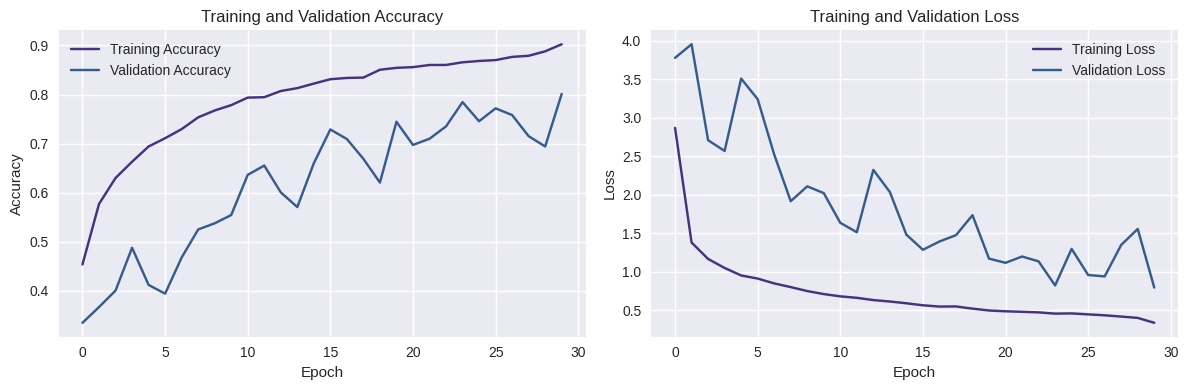

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import shutil
import zipfile


# Define parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 30  # Increased to allow more training, with early stopping
TARGET_COUNT = 867  # Target number of images per class for oversampling

# Get class names
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"Class names: {class_names}")

# Create Oversampled_Train directory
os.makedirs(train_dir_stratified, exist_ok=True)

# Oversample minority classes
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    new_class_path = os.path.join(train_dir_stratified, class_name)
    os.makedirs(new_class_path, exist_ok=True)

    # Get list of images
    images = glob.glob(os.path.join(class_path, '*.*'))
    original_count = len(images)
    max_count = min(TARGET_COUNT, original_count * 3)  # Cap at 3x original count

    # Copy original images
    for img in images:
        shutil.copy(img, new_class_path)

    # Oversample by duplicating images
    current_count = original_count
    if current_count < max_count:
        for i in range(max_count - current_count):
            img_to_copy = images[i % current_count]
            new_img_name = f"{os.path.splitext(os.path.basename(img_to_copy))[0]}_copy{i}.jpg"
            shutil.copy(img_to_copy, os.path.join(new_class_path, new_img_name))

    print(f"Oversampled {class_name}: {len(glob.glob(os.path.join(new_class_path, '*.*')))} images")

print(f"Oversampled_Train directory created at: {train_dir_stratified}")

# Create Stratified_val directory
os.makedirs(val_dir_stratified, exist_ok=True)

# Split 20% of Train data for validation
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    val_class_path = os.path.join(val_dir_stratified, class_name)
    os.makedirs(val_class_path, exist_ok=True)

    # Get list of images
    images = glob.glob(os.path.join(class_path, '*.*'))
    if len(images) > 0:
        # Split 20% for validation
        _, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
        for img in val_imgs:
            shutil.copy(img, val_class_path)

    print(f"Validation {class_name}: {len(glob.glob(os.path.join(val_class_path, '*.*')))} images")

print(f"Stratified_val directory created at: {val_dir_stratified}")

# Verify and create test set if missing
if not os.path.exists(test_dir) or len(os.listdir(test_dir)) == 0:
    print("Test directory not found or empty. Creating test set from Train...")
    os.makedirs(test_split_dir, exist_ok=True)
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        images = glob.glob(os.path.join(class_path, '*.*'))
        if len(images) > 0:
            # Split 10% of Train data into Test
            _, test_imgs = train_test_split(images, test_size=0.1, random_state=42)
            test_class_path = os.path.join(test_split_dir, class_name)
            os.makedirs(test_class_path, exist_ok=True)
            for img in test_imgs:
                shutil.copy(img, test_class_path)
    print(f"Test directory created at: {test_split_dir}")
    test_dir = test_split_dir
else:
    print(f"Test directory found at: {test_dir}")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Preprocessing for validation and testing (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir_stratified,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir_stratified,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(base_dir, 'models/mobilenetv2_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'plots/training_curves.png'))
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Generate predictions for test set
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(base_dir, 'plots/confusion_matrix.png'))
plt.show()

# ONLY CHANGE: Save the final model to Google Drive
os.makedirs('/content/drive/My Drive/models', exist_ok=True)
model.save('/content/drive/My Drive/models/mobilenetv2_final.h5')
print(f"Final model saved at: /content/drive/My Drive/models/mobilenetv2_final.h5")


=== EVALUATING SAVED MODELS ===

Loading baseline...


baseline - Test Accuracy: 0.1186, Test Loss: 28.0237

Loading improved_deep_adam...


improved_deep_adam - Test Accuracy: 0.3475, Test Loss: 2.1288

Loading improved_deep_sgd...


improved_deep_sgd - Test Accuracy: 0.1610, Test Loss: 17.1159

Loading mobilenetv2...


mobilenetv2 - Test Accuracy: 0.3051, Test Loss: 1.9513

Loading efficient_skin...


efficient_skin - Test Accuracy: 0.1610, Test Loss: 19.0752

Loading lightweight...
lightweight - Test Accuracy: 0.1017, Test Loss: 2.9871

=== MODEL COMPARISON SUMMARY ===
                    accuracy       loss  parameters
improved_deep_adam  0.347458   2.128798   2588233.0
mobilenetv2         0.305085   1.951252   2588233.0
efficient_skin      0.161017  19.075201    139593.0
improved_deep_sgd   0.161017  17.115873   4885545.0
baseline            0.118644  28.023724  22286409.0
lightweight         0.101695   2.987120     36521.0


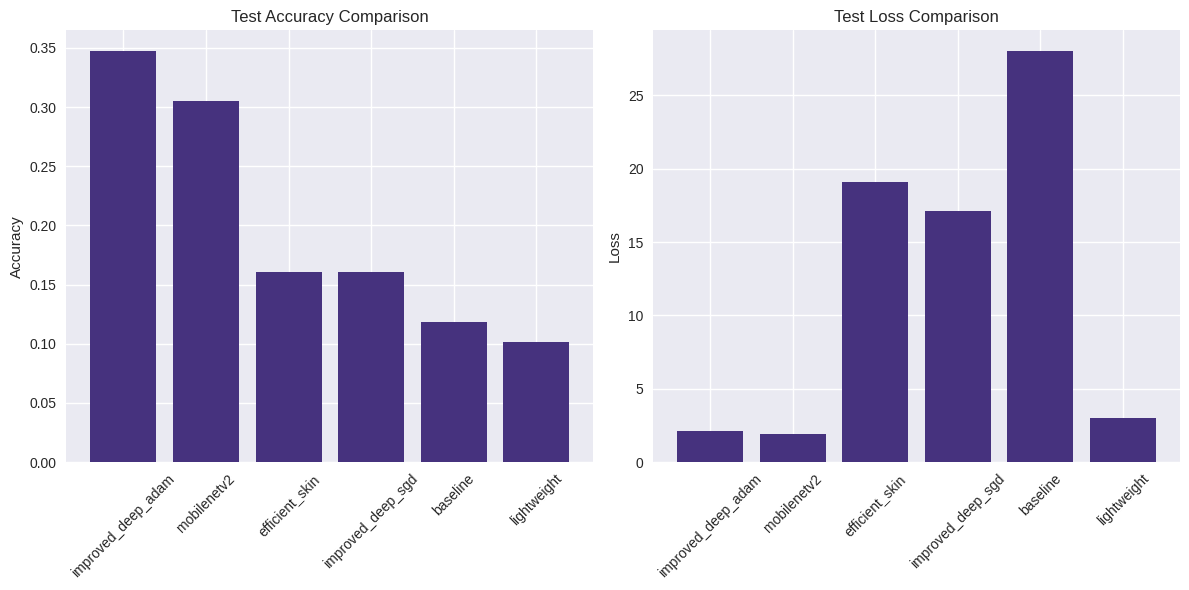


Loading best model: improved_deep_adam


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

Detailed Classification Report for improved_deep_adam:
                            precision    recall  f1-score   support

         actinic keratosis       0.62      0.31      0.42        16
      basal cell carcinoma       0.35      0.44      0.39        16
            dermatofibroma       1.00      0.25      0.40        16
                  melanoma       0.22      0.25      0.24        16
                     nevus       0.34      0.69      0.46        16
pigmented benign keratosis       0.28      0.31      0.29        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.33      0.12      0.18        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.35       118
                 macro avg       0.43      0.38      0.36       118
              weighted avg       0.45      0.35      0.34       118



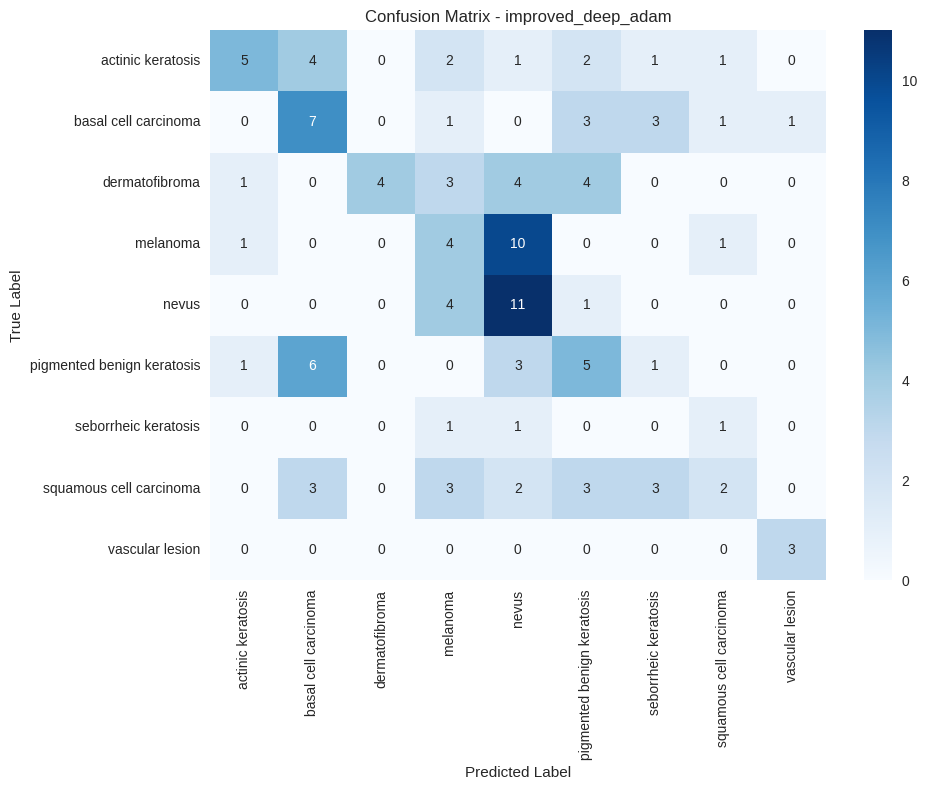

In [ ]:
# Load and evaluate saved models
from tensorflow.keras.models import load_model

# Define paths to your saved models
saved_models = {
    'baseline': '/content/drive/My Drive/models/baseline_best.h5',
    'improved_deep_adam': '/content/drive/My Drive/models/improved_deep_best.h5',
    'improved_deep_sgd': '/content/drive/My Drive/models/improved_deep_sgd_best.h5',
    'mobilenetv2': '/content/drive/My Drive/models/mobilenetv2_best.h5',
    'efficient_skin': '/content/drive/My Drive/models/efficient_skin_model.h5',
    'lightweight': '/content/drive/My Drive/models/lightweight_best.h5'
}

# Create test generator (if not already created)
if 'test_generator' not in locals():
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print(f"Test samples: {test_generator.samples}")

# Load and evaluate each model
print("\n=== EVALUATING SAVED MODELS ===")
model_results = {}

for model_name, model_path in saved_models.items():
    if os.path.exists(model_path):
        try:
            print(f"\nLoading {model_name}...")
            loaded_model = load_model(model_path)

            # Evaluate on test set
            test_generator.reset()
            test_loss, test_accuracy = loaded_model.evaluate(test_generator, verbose=0)

            # Store results
            model_results[model_name] = {
                'accuracy': test_accuracy,
                'loss': test_loss,
                'parameters': loaded_model.count_params()
            }

            print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
    else:
        print(f"{model_name} model not found at {model_path}")

# Display results summary
print("\n=== MODEL COMPARISON SUMMARY ===")
if model_results:
    df_results = pd.DataFrame(model_results).T
    df_results = df_results.sort_values('accuracy', ascending=False)
    print(df_results)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(df_results.index, df_results['accuracy'])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(df_results.index, df_results['loss'])
    plt.title('Test Loss Comparison')
    plt.ylabel('Loss')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('plots/model_comparison_results.png', dpi=300)
    plt.show()

# Load the best performing model for further analysis
if model_results:
    best_model_name = max(model_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model_path = saved_models[best_model_name]

    print(f"\nLoading best model: {best_model_name}")
    best_model = load_model(best_model_path)

    # Get detailed predictions for best model
    test_generator.reset()
    predictions = best_model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # Classification report for best model
    print(f"\nDetailed Classification Report for {best_model_name}:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Confusion matrix for best model
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'plots/confusion_matrix_{best_model_name}.png', dpi=300)
    plt.show()

Found 118 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Model loaded successfully from /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5511 - loss: 2.2196
MobileNetV2 Test Accuracy: 0.6017
MobileNetV2 Test Loss: 2.0127
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

Classification Report for MobileNetV2:
                            precision    recall  f1-score   support

         actinic keratosis     0.0000    0.0000    0.0000        16
      basal cell carcinoma     0.9333    0.8750    0.9032        16
            dermatofibroma     0.6667    0.8750    0.7568        16
                  melanoma     0.5714    0.2500    0.3478        16
                     nevus     0.3939    0.8125    0.5306        16
pigmented benign keratosis     0.4828    0.8750    0.6222        16
      seborrheic keratosis     1.0000    0.3333    0.5000         3
   squamous cell carcinoma     0.8889    0.5000    0.6400        16
           vascular lesion     1.0000    1.0000    1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


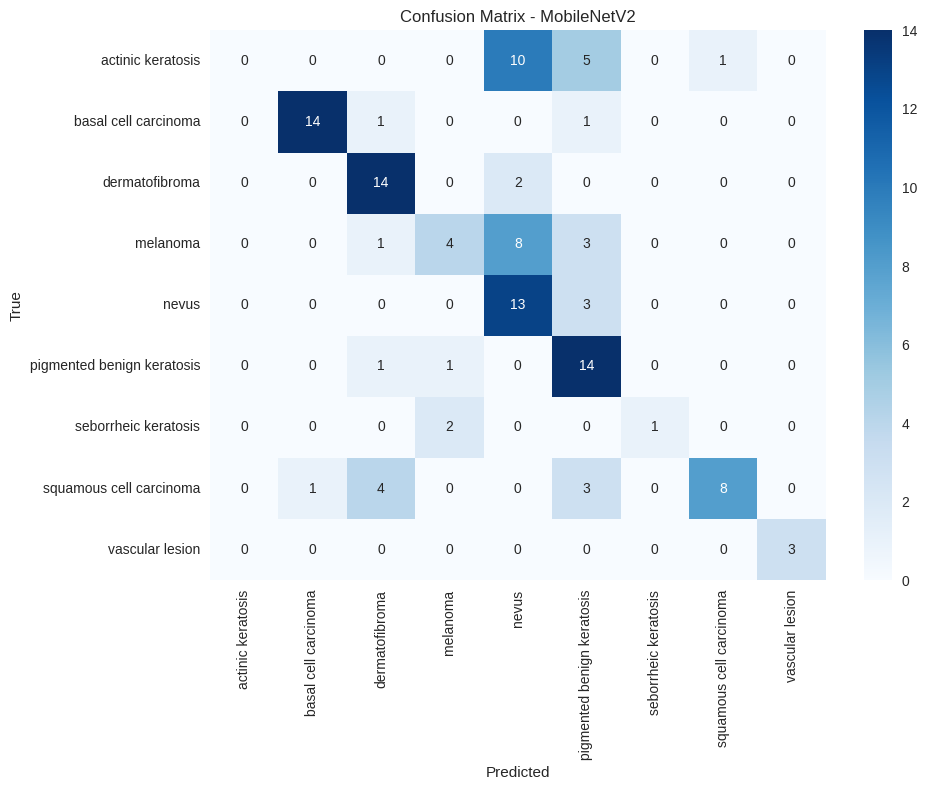

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 9
test_dir = '/content/Skin_Cancer_Classification/Skin Cancer Classification/Test'

# Create test data generator
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load the saved MobileNetV2 model
model_path = '/content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5'
try:
    model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {str(e)}")
    exit()

# Evaluate the model on the test set
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"MobileNetV2 Test Accuracy: {test_accuracy:.4f}")
print(f"MobileNetV2 Test Loss: {test_loss:.4f}")

# Generate predictions for detailed analysis
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report for MobileNetV2:")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - MobileNetV2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('plots/confusion_matrix_mobilenetv2.png', dpi=300)
plt.show()

Loading model from: /content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5


Found test directory: /content/Skin_Cancer_Classification/Skin Cancer Classification/Test


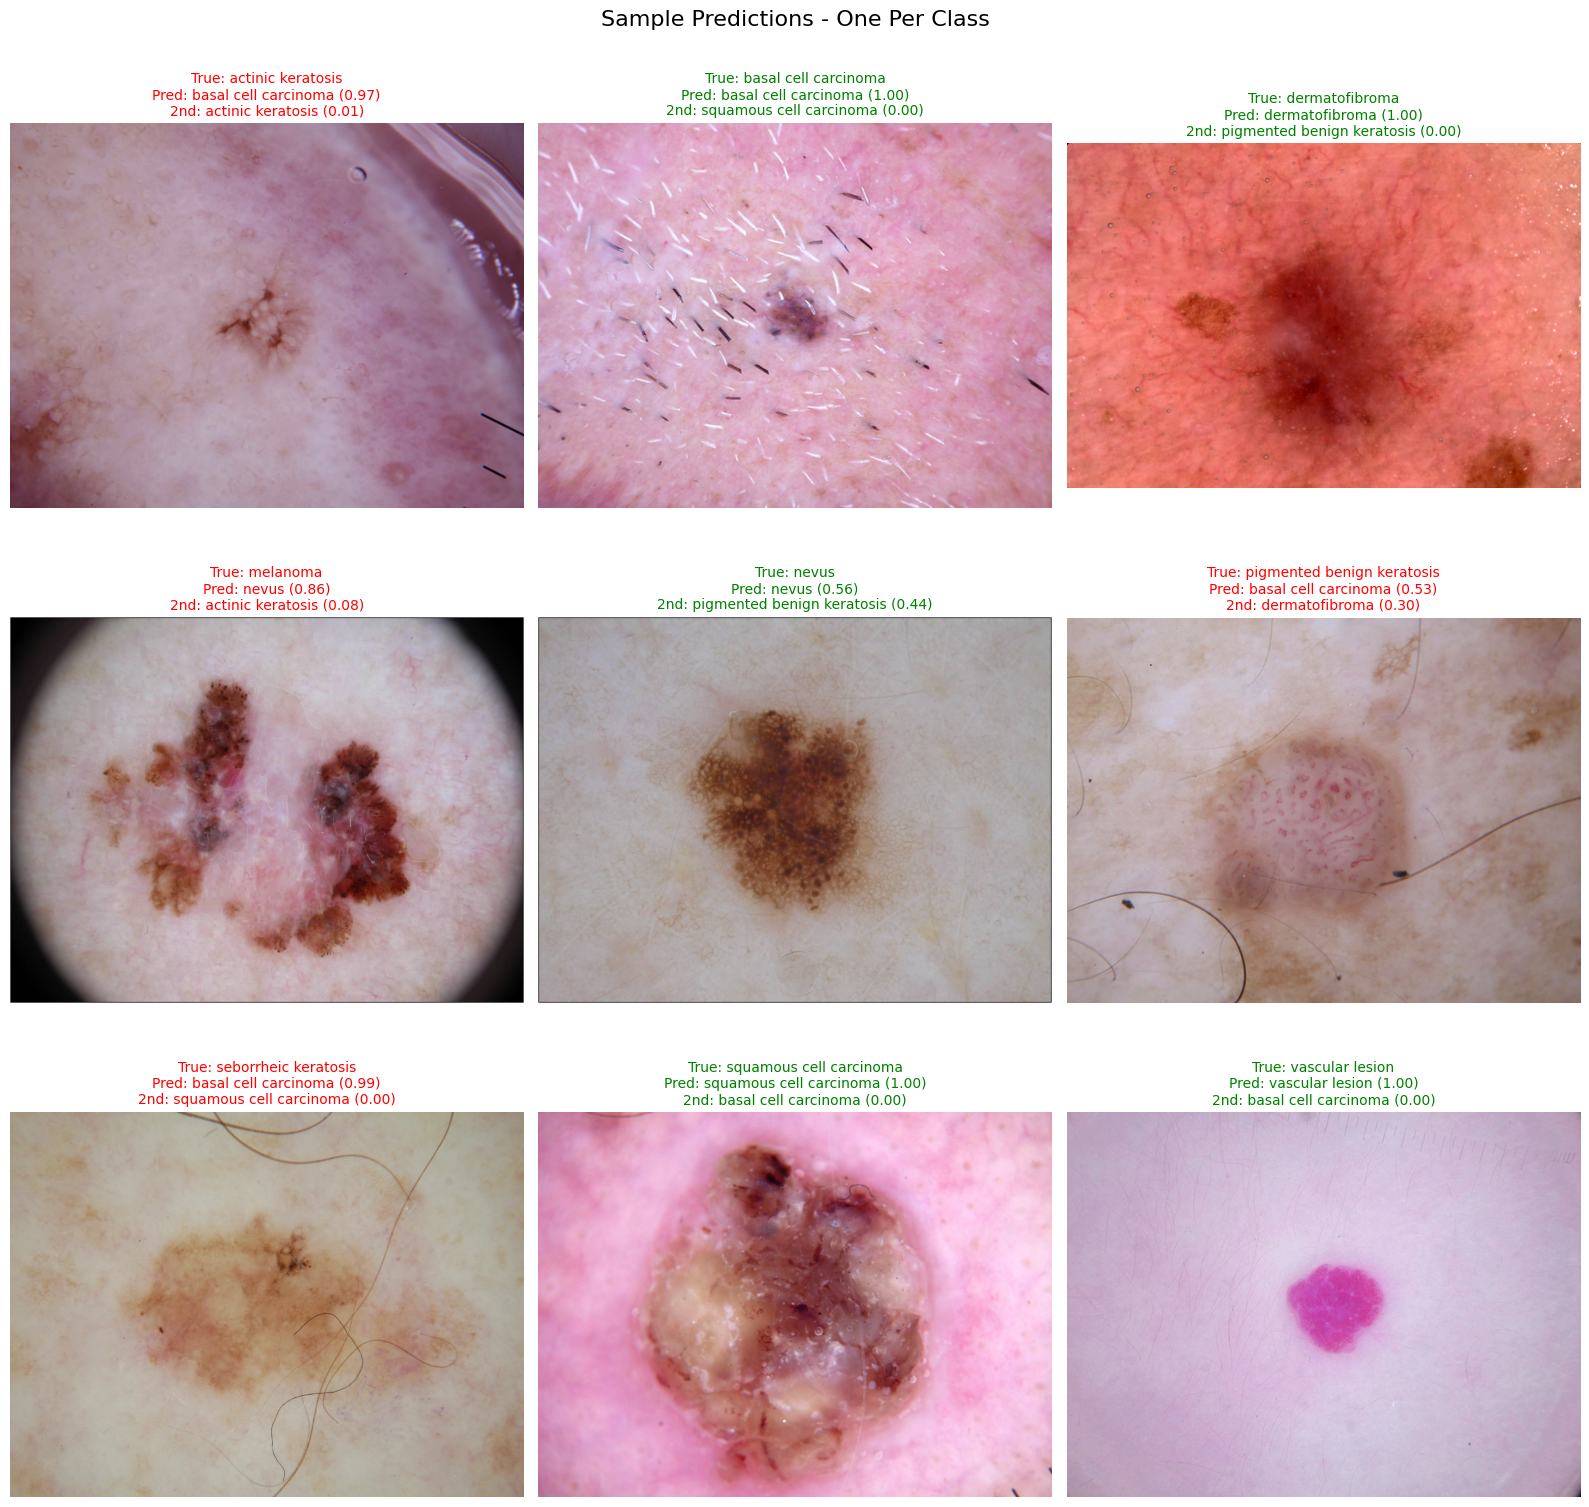

Predictions saved to 'predictions_like_screenshot.png'


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import glob

# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Define the exact classes as shown in the screenshot
class_names = [
    'actinic keratosis',
    'basal cell carcinoma',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pigmented benign keratosis',
    'seborrheic keratosis',
    'squamous cell carcinoma',
    'vascular lesion'
]

# Load the best model (try different paths)
model_paths = [
    '/content/Skin_Cancer_Classification/Skin Cancer Classification/models/mobilenetv2_best.h5'
]

model = None
for path in model_paths:
    if os.path.exists(path):
        print(f"Loading model from: {path}")
        model = load_model(path)
        break

if model is None:
    print("No model found! Please check model paths.")
    exit()

# Find the test directory
base_paths = [
    '/content/Skin_Cancer_Classification/Skin Cancer Classification',
    '/content/Skin_Cancer_Classification',
    '/content'
]

test_dir = None
for base in base_paths:
    for root, dirs, files in os.walk(base):
        if "Test" in dirs:
            test_dir = os.path.join(root, "Test")
            if os.path.isdir(test_dir) and os.listdir(test_dir):
                print(f"Found test directory: {test_dir}")
                break
    if test_dir:
        break

if not test_dir:
    print("Test directory not found!")
    exit()

# Create a 3x3 grid for the 9 classes
plt.figure(figsize=(16, 16))

# Collect one image from each class
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(test_dir, class_name)

    # Skip if class directory doesn't exist
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    # Get images from class directory
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not images:
        print(f"No images found in {class_dir}")
        continue

    # Choose first image
    img_path = os.path.join(class_dir, images[0])

    # Create subplot
    plt.subplot(3, 3, i+1)

    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

    # Prepare image for prediction
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_array = img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    pred_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][pred_class_idx]

    # Get second highest prediction
    sorted_indices = np.argsort(prediction[0])[::-1]
    second_idx = sorted_indices[1]
    second_confidence = prediction[0][second_idx]

    # Format title exactly like in the screenshot
    true_label = f"True: {class_name}"
    pred_label = f"Pred: {class_names[pred_class_idx]} ({confidence:.2f})"
    second_label = f"2nd: {class_names[second_idx]} ({second_confidence:.2f})"

    # Set color based on prediction correctness
    color = 'green' if class_name == class_names[pred_class_idx] else 'red'

    # Set title with the exact format from screenshot
    plt.title(f"{true_label}\n{pred_label}\n{second_label}", color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('Sample Predictions - One Per Class', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('predictions_like_screenshot.png', dpi=300)
plt.show()
print("Predictions saved to 'predictions_like_screenshot.png'")